# Patern Identification for strategy design- Machine Learning Approach 

## Structure
 ### 1. Pattern implementation : collection and analysis of market data
  #### a. Collecting market data
  #### b. Creation of Patterns (technical analysis)
 ### 2. Machine Learning and trading strategy
  #### a. Finding the accuracy of Patterns
  #### b. Finding the horizon of trading
  #### c. Finding the best stop loss and take profit %
  #### d. Machine Learning 
 ### 3. Decision and Execution
  #### a. Decision (buy or sell) based on machine Learning
  #### b. Backtesting
  #### c. Portfolio


This project is a development project for an automatic trading algorithm.

It is based on pattern analysis, which identifies signals on stock price charts to determine potential market trends. We also use a machine learning approach to optimize the trading strategy. 

Initially, we created a program to extract information and generate stock price charts. 

Then, we coded various patterns and displayed them on the charts to identify potential future trends. We selected these different patterns to ensure our portfolio of patterns was diverse and as efficient as possible. 

Next, we analyzed statistics on the success rates of the predictions for these different patterns over different time horizons. We used multiple charts of prices for different stocks to ensure our statistics were as realistic as possible for the overall market. 

Using all these statistics, we plan to determine the most effective weightings for the different patterns via machine learning and back-testing (simulation and evaluation of the strategy based on price evolution in the past). This will enable us to finalize the trading strategy and implement it.


# 1. Pattern Implementation

## Collecting Market Data

### Install packages

In [1]:
pip install googleapis-common-protos protobuf grpcio pandas matplotlib


[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas-datareader


[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install yfinance


[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U scikit-learn


[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Import Packages

In [5]:
import os
import grpc
import pandas as pd
from datetime import datetime
import google.type.date_pb2 as date
import google.type.dayofweek_pb2 as dayofweek
import google.type.timeofday_pb2 as timeofday
import google.protobuf.duration_pb2 as duration
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

import google.protobuf as pb

import yfinance as yf

import random

import grpc
import time

from datetime import datetime, timedelta

from typing import List

### Retrieve Prices

In [6]:
def get_stock_data(symbol):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=1000)
    df = yf.download(symbol, start=start_date, end=end_date)

    # Rename the columns to match the original code
    df = df.reset_index().rename(columns={'Date': 'Date', 'Open': 'Open', 'High': 'High', 'Low': 'Low', 'Close': 'Close', 'Volume': 'Volume', 'Adj Close': 'Adj Close'})

    return df, symbol

In [7]:
def get_nasdaq_tickers():
    file="/Users/thomas/project/Nasdaq_tech.csv"
    df = pd.read_csv(file)
    tickers = df['Symbol'].tolist()
    return tickers

def get_tickers(n):
    tickers = get_nasdaq_tickers()
    random_tickers = random.sample(tickers, n)
    return random_tickers

# Example usage
random_tickers = get_tickers(100)
print(random_tickers)


['CSWC', 'ADEA', 'MYFW', 'HTLFP', 'WSBC', 'ZION', 'RDFN', 'FITBP', 'SNCR', 'BOKF', 'CTSH', 'COMM', 'FFNW', 'NTRSO', 'ANGI', 'TBLAW', 'WTBA', 'LPSN', 'GABC', 'LOGI', 'SWKS', 'FBNC', 'OXLCN', 'WHF', 'ALGM', 'NVMI', 'AMAT', 'INTC', 'BSRR', 'HBNC', 'CERT', 'SFNC', 'MAPSW', 'XNET', 'HLTH', 'WTW', 'NTAP', 'FSBC', 'CBSH', 'BPYPO', 'IMOS', 'STBA', 'DSP', 'VCSA', 'VINP', 'GSIT', 'QCOM', 'BANF', 'TCBX', 'CCSI', 'CRWD', 'HWC', 'BUSE', 'HLNE', 'CIFR', 'NWBI', 'FIBK', 'NTCT', 'SSYS', 'PFBC', 'BHFAP', 'SPNS', 'CFLT', 'VCTR', 'HTBI', 'LBC', 'NRIM', 'COLB', 'NCNO', 'FORM', 'ESSA', 'BRZE', 'LTCHW', 'TFSL', 'BIDU', 'HNVR', 'LRFC', 'FITBO', 'INTA', 'FROG', 'LTRPA', 'NMRK', 'ZBRA', 'LTCH', 'BANFP', 'VIRT', 'UFCS', 'SPI', 'VRSN', 'MORN', 'BANR', 'MKTX', 'WDAY', 'HIMX', 'RNST', 'FNLC', 'SDGR', 'DHIL', 'KLAC', 'EXFY']


In [8]:
df,ticker = get_stock_data("AAPL")

[*********************100%***********************]  1 of 1 completed


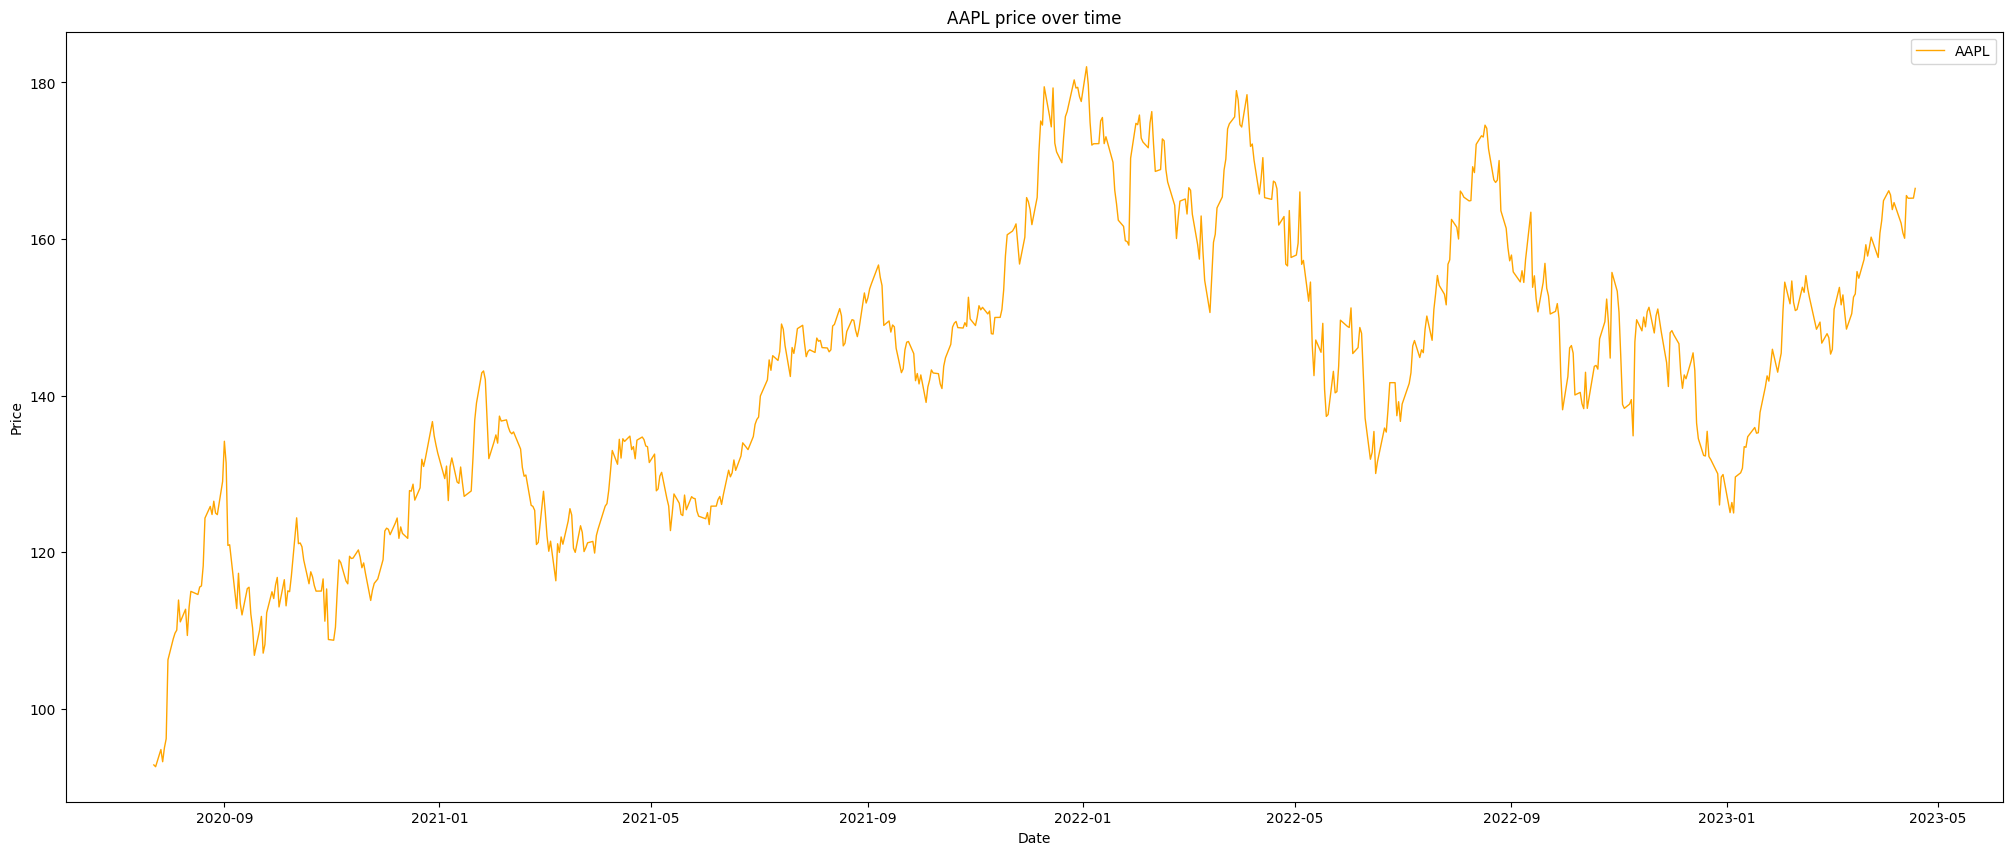

In [9]:
plt.figure(figsize=(25, 10))
plt.plot('Date', 'Close', data=df, marker='', color='orange', linewidth=1, label="{}".format(ticker))
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("{0} price over time".format(ticker))
plt.legend()

### Creation of Patterns

#### Helper functions

##### Range function

In [10]:
def is_in_range(price, low, high):
    if low <= price <= high:
        return True
    else:
        return False

In [11]:
def is_price_in_range(price, range_start, range_end, time_period):
        # Check if the price is within the given range
        if range_start <= price <= range_end:
            # Check if the time period has passed
            if time_period > 0:
                # Decrement the time period and check again in the next iteration
                return is_price_in_range(price, range_start, range_end, time_period - 1)
            else:
                # The time period has passed, so return True
                return True
        else:
            # The price is not within the range, so return False
            return False

In [12]:
def is_price_in_high_range(price, range_start, range_end, time_period):
    # Calculate the midpoint of the range
    range_midpoint = (range_start + range_end) / 2

    # Check if the price is above the midpoint of the range
    return is_price_in_range(price, range_midpoint, range_end, time_period)

def is_price_in_low_range(price, range_start, range_end, time_period):
    # Calculate the midpoint of the range
    range_midpoint = (range_start + range_end) / 2

    # Check if the price is below the midpoint of the range
    return is_price_in_range(price, range_start, range_midpoint, time_period)


##### Higher highs : 

In [13]:
def check_for_higher_highs(stock_data, index, time_period):
    current_high = stock_data.iloc[index]['High']
    current_close = stock_data.iloc[index]['Close']
    previous_highs = [stock_data.iloc[i]['High'] for i in range(index-time_period, index)]
    if current_high > max(previous_highs) and current_close < max(previous_highs):
        return True
    return False

##### Lower Lows : 

In [14]:
def check_for_lower_lows(stock_data, index, time_period):
    current_low = stock_data.iloc[index]['Low']
    current_close = stock_data.iloc[index]['Close']
    previous_lows = [stock_data.iloc[i]['Low'] for i in range(index-time_period, index)]
    if current_low < min(previous_lows) and current_close > min(previous_lows):
        return True
    return False

##### Support and Resistance

In [15]:
def calculate_support_resistance(stock_data, window_size):
    # calculate simple moving average
    sma = stock_data['Close'].rolling(window=window_size).mean()
    # find support and resistance levels
    support = sma.rolling(window=window_size).min()
    resistance = sma.rolling(window=window_size).max()
    return support, resistance

##### Trend

In [16]:
def calculate_trend(stock_data, window_size):
    trend_data = []
    for i in range(len(stock_data)):
        if i < window_size:
            trend_data.append("NA")
        else:
            window = stock_data.iloc[i-window_size:i]
            window_max = window['Close'].max()
            window_min = window['Close'].min()
            current_close = stock_data.iloc[i]['Close']
            if current_close > window_max:
                trend_data.append("Up")
            elif current_close < window_min:
                trend_data.append("Down")
            else:
                trend_data.append("NA")
    return trend_data

##### Plot function

In [17]:
def plot_patterns(df, pattern_funcs, params):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(25, 10))

    # Plot the stock data
    ax.plot(df.index, df['Close'], marker='', color='orange', linewidth=1, label="{}".format(ticker))
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.set_title("{0} price over time".format(ticker))
    ax.legend()

    # Iterate through the pattern functions
    for pattern_func in pattern_funcs:
        pattern_indexes = pattern_func(df, **params[pattern_func.__name__])
        
        if any(x == -1 for x in pattern_indexes) :
            # Iterate through the bullish index values
            for i in range (len(pattern_indexes)):
                # Get the x and y coordinates for the index value
                x = df.index[i]
                y = df.iloc[i]['Close']
                if pattern_indexes[i]==1:
                    ax.text(x, y, pattern_func.__name__[0], color="green", fontsize=12, va="bottom", ha="left")

                elif pattern_indexes[i]==-1:
                    ax.text(x, y, pattern_func.__name__[0], color="red", fontsize=12, va="bottom", ha="left")
        else:
            for i in range (len(pattern_indexes)):
                if pattern_indexes[i]==1:
                    # Get the x and y coordinates for the index value
                    x = df.index[i]
                    y = df.iloc[i]['Close']
                    ax.text(x, y, pattern_func.__name__[0], color="black", fontsize=12, va="bottom", ha="left")
    # Adjust the axis limits to fit the letters on the graph
    plt.tight_layout()

    # Show the plot
    plt.show()


#### Patterns : 

Window size and time period parameters :

In [18]:
params = {
    'Cobra': {'window_size': 1, 'time_period': 5},
    'Hook': {'window_size': None, 'time_period': None},
    'Tail': {'window_size': 1, 'time_period': 1},
    'Harami': {'window_size': None, 'time_period': None},
    'Test': {'window_size': None, 'time_period': None},
    'Pullback': {'window_size': 1, 'time_period': 5},
    'Vzone': {'window_size': 5, 'time_period': 5},
    'Doji': {'window_size': None, 'time_period': None},
    'Hammer': {'window_size': None, 'time_period': None},
    'Volume_Climax': {'window_size': None, 'time_period': None},
    'OBV': {'window_size': 1, 'time_period': 4},
    'MeanReversion':{'window_size': 3, 'time_period': 2}
}

#### Cobra

##### Bullish and Bearish Cobra 
For a bullish Cobra the open must be in the bottom of the range, and the close must be in the top

For a bearish Cobra, the open must be in the top of the range, and the close must be in the bottom of the range.

In [19]:
def is_bullish_cobra(open_price, close_price, range_start, range_end, time_period):
    # Check if the open price is in the bottom half of the range
    is_open_in_low_range = is_price_in_low_range(open_price, range_start, range_end, time_period)
    
    # Check if the close price is in the top half of the range
    is_close_in_high_range = is_price_in_high_range(close_price, range_start, range_end, time_period)
    
    return is_open_in_low_range and is_close_in_high_range


In [20]:
def is_bearish_cobra(open_price, close_price, range_start, range_end, time_period):
    # Check if the open price is in the top half of the range
    is_open_in_high_range = is_price_in_high_range(open_price, range_start, range_end, time_period)
    
    # Check if the close price is in the bottom half of the range
    is_close_in_low_range = is_price_in_low_range(close_price, range_start, range_end, time_period)
    
    return is_open_in_high_range and is_close_in_low_range

In [21]:
def Cobra(prices, window_size=1, time_period=4):
    cobra = [0] * len(prices)
    for i in range(1, len(prices)):
        window = prices['Close'][max(0, i - window_size - time_period + 1):i]  # Get the prices for the current window
        if window.empty:  # Check if the window is not empty
            continue
        range_start = min(window)  # The range start is the lowest price in the window
        range_end = max(window)  # The range end is the highest price in the window
        open_price = prices['Open'][i]
        close_price = prices['Close'][i]
        if is_bearish_cobra(open_price, close_price, range_start, range_end, time_period):
            cobra[i] = -1
        elif is_bullish_cobra(open_price, close_price, range_start, range_end, time_period):
            cobra[i] = 1
        else:
            cobra[i] = 0
    return cobra

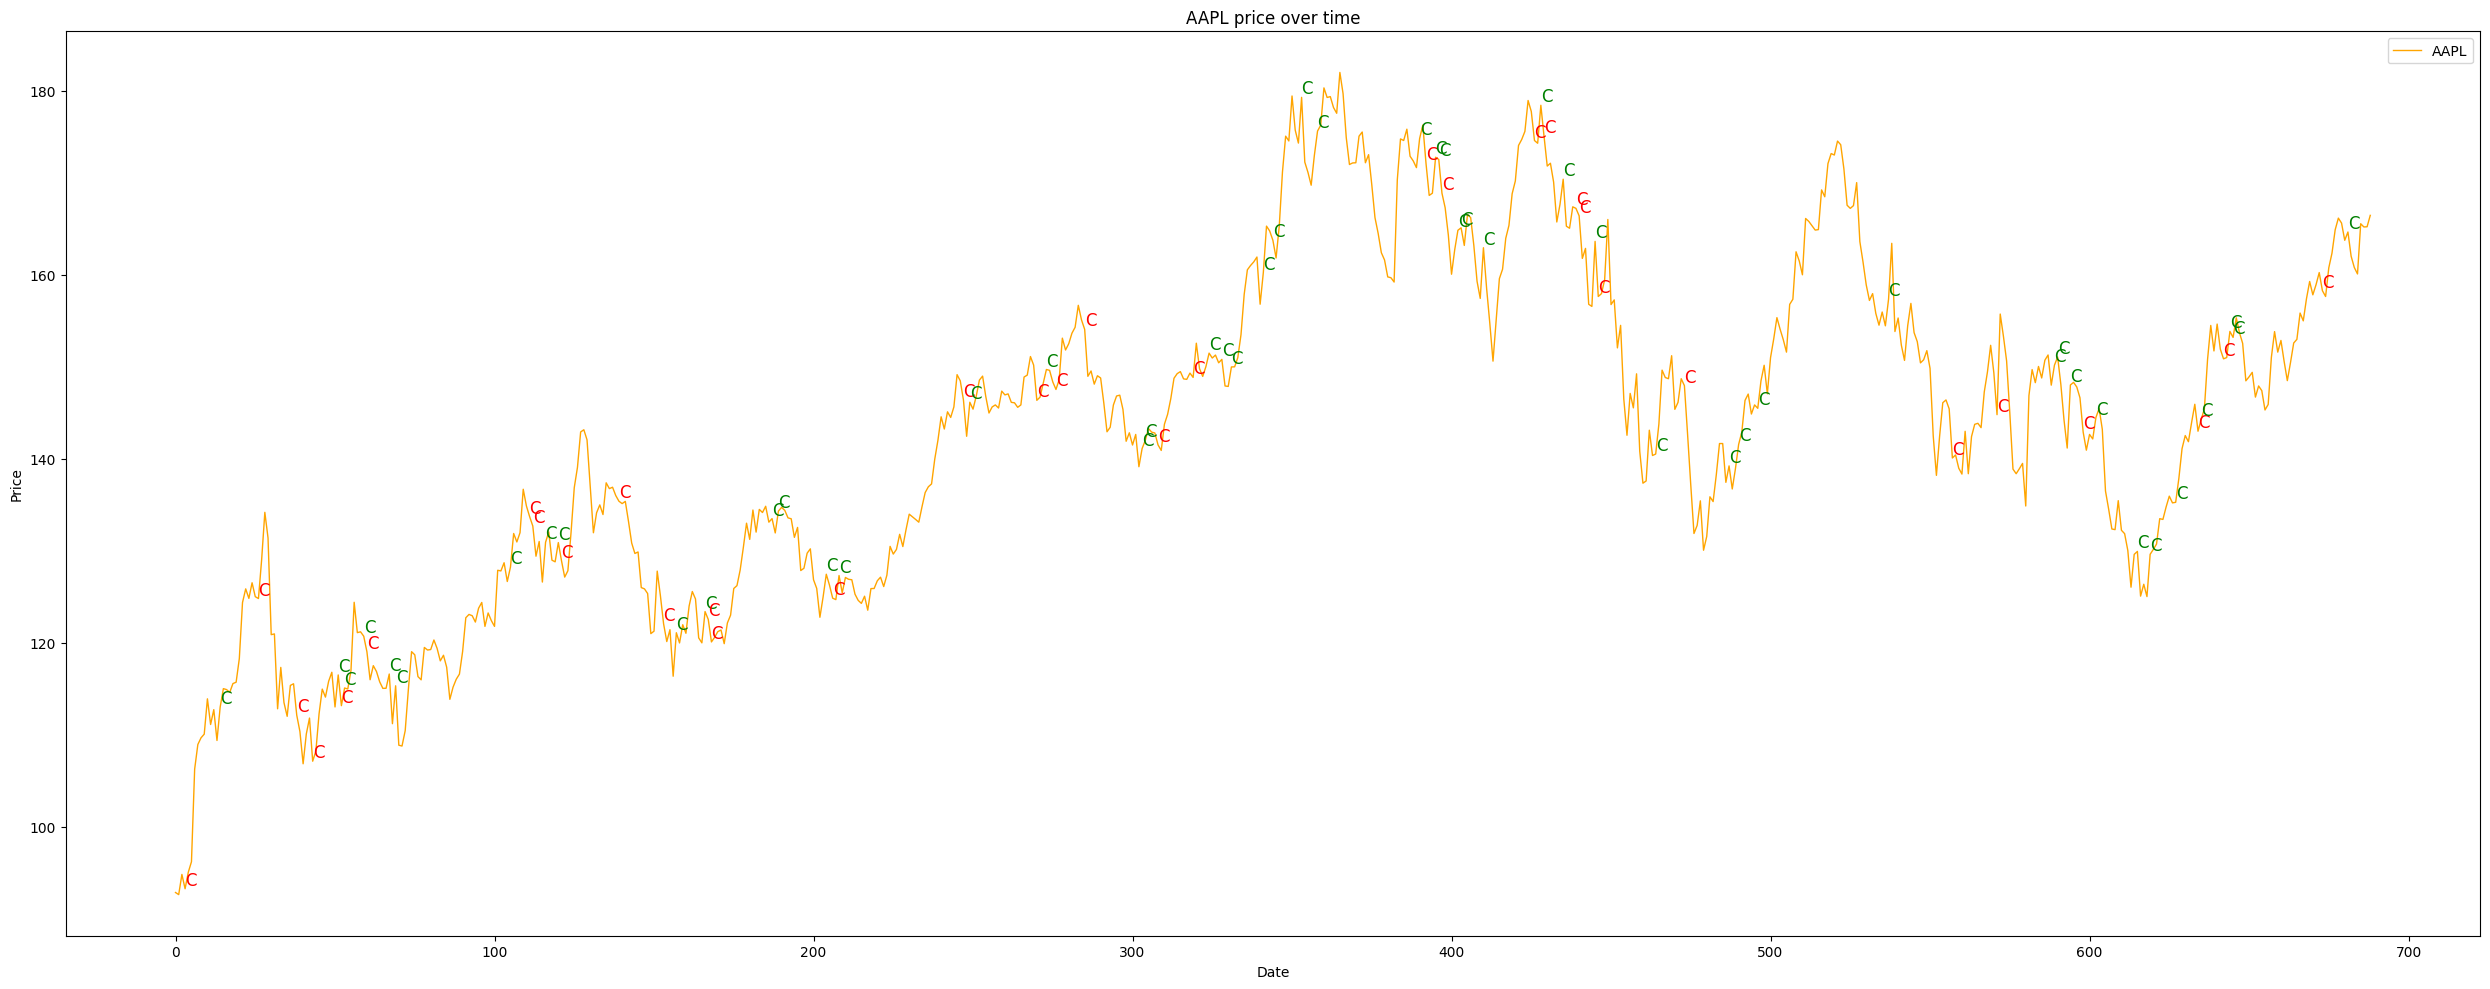

In [22]:
# Create a list of pattern functions to pass to the plot_patterns function
pattern_funcs = [Cobra]

# Call the plot_patterns function
plot_patterns(df, pattern_funcs, params)

##### Hook :
A Hook is a retracement bar that appears to reverse the retracement trend but then closes in the direction of the retracement.

The bullish case is characterized by an upward trend, followed by a downward retracement, followed by a sharp upward trend again.
The bearish case is characterized by a downward trend, followed by a sharp upward trend, followed by a downward trend again.

In [23]:
def Hook(stock_data,window_size, time_period):
    hook = [0] * len(stock_data)
    for i in range(2,len(stock_data)):
        if stock_data.iloc[i-1]['Close'] > stock_data.iloc[i-2]['Close'] and stock_data.iloc[i]['Close'] < stock_data.iloc[i-1]['Close']:
            hook[i]=1
        elif stock_data.iloc[i-1]['Close'] < stock_data.iloc[i-2]['Close'] and stock_data.iloc[i]['Close'] > stock_data.iloc[i-1]['Close']: 
            hook[i]=-1
        else:
            hook[i]=0
    return hook

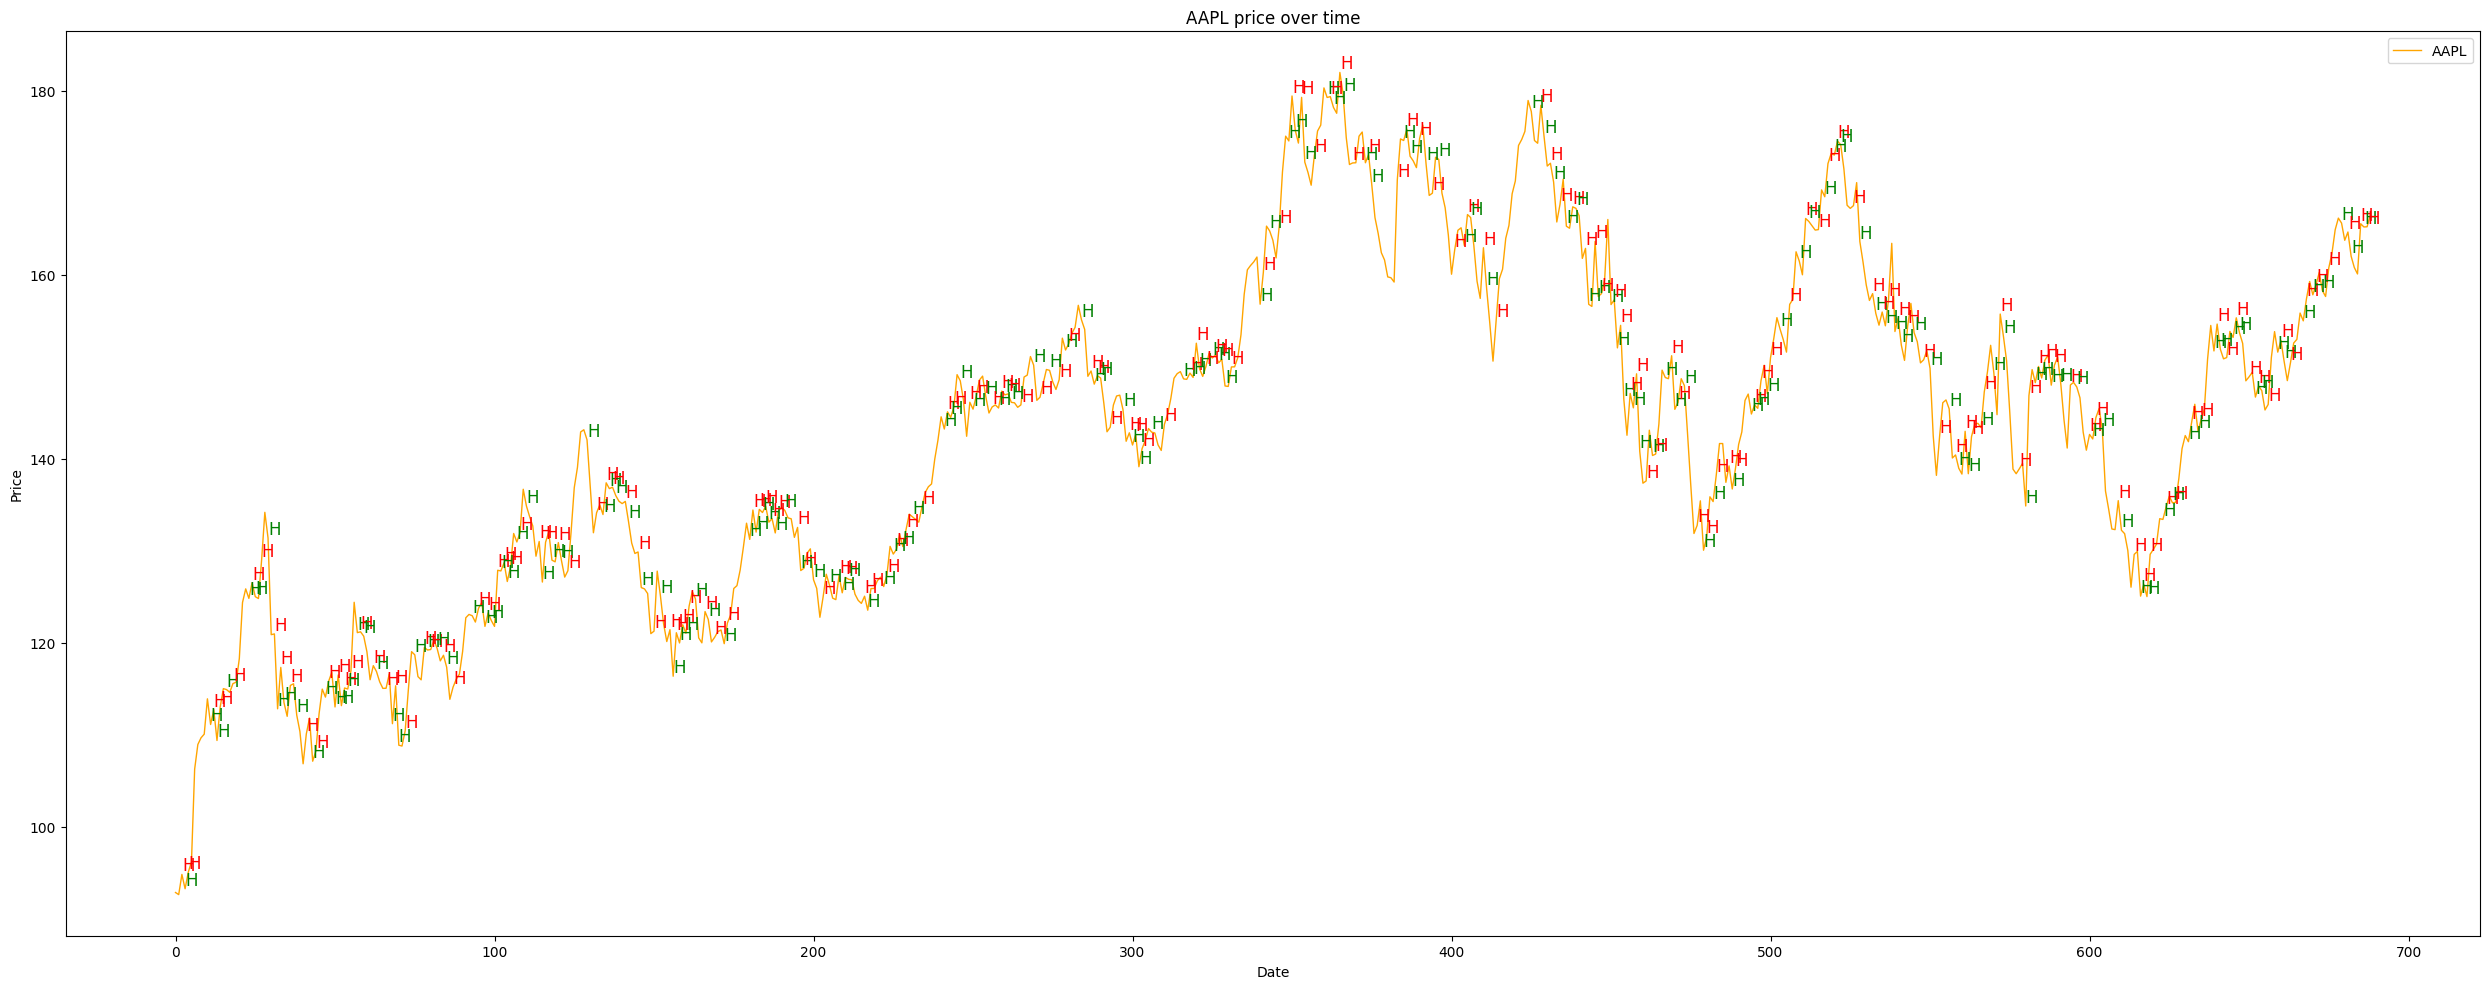

In [24]:
# Create a list of pattern functions to pass to the plot_patterns function
pattern_funcs = [Hook]

# Call the plot_patterns function
plot_patterns(df, pattern_funcs, params)

##### Tail :
A Tail is a bar where the open and close are in the same half-bar. If both the close and open are in the upper half of the range, then that is a bullish tail . If both the close and open are in the lower half of the range, then that is a bearish tail.

In [25]:
def Tail(stock_data, window_size=1, time_period=1):
    tail = []
    for i in range(len(stock_data)):
        high = stock_data.iloc[i]['High']
        low = stock_data.iloc[i]['Low']
        open_= stock_data.iloc[i]['Open']
        close = stock_data.iloc[i]['Close']
        
        if is_price_in_high_range(open_, low, high, time_period) and is_price_in_high_range(close, low, high, time_period):
            tail.append(1)
        elif is_price_in_low_range(open_, low, high, time_period) and is_price_in_low_range(close, low, high, time_period):
            tail.append(-1)
        else:
            tail.append(0)
    return tail

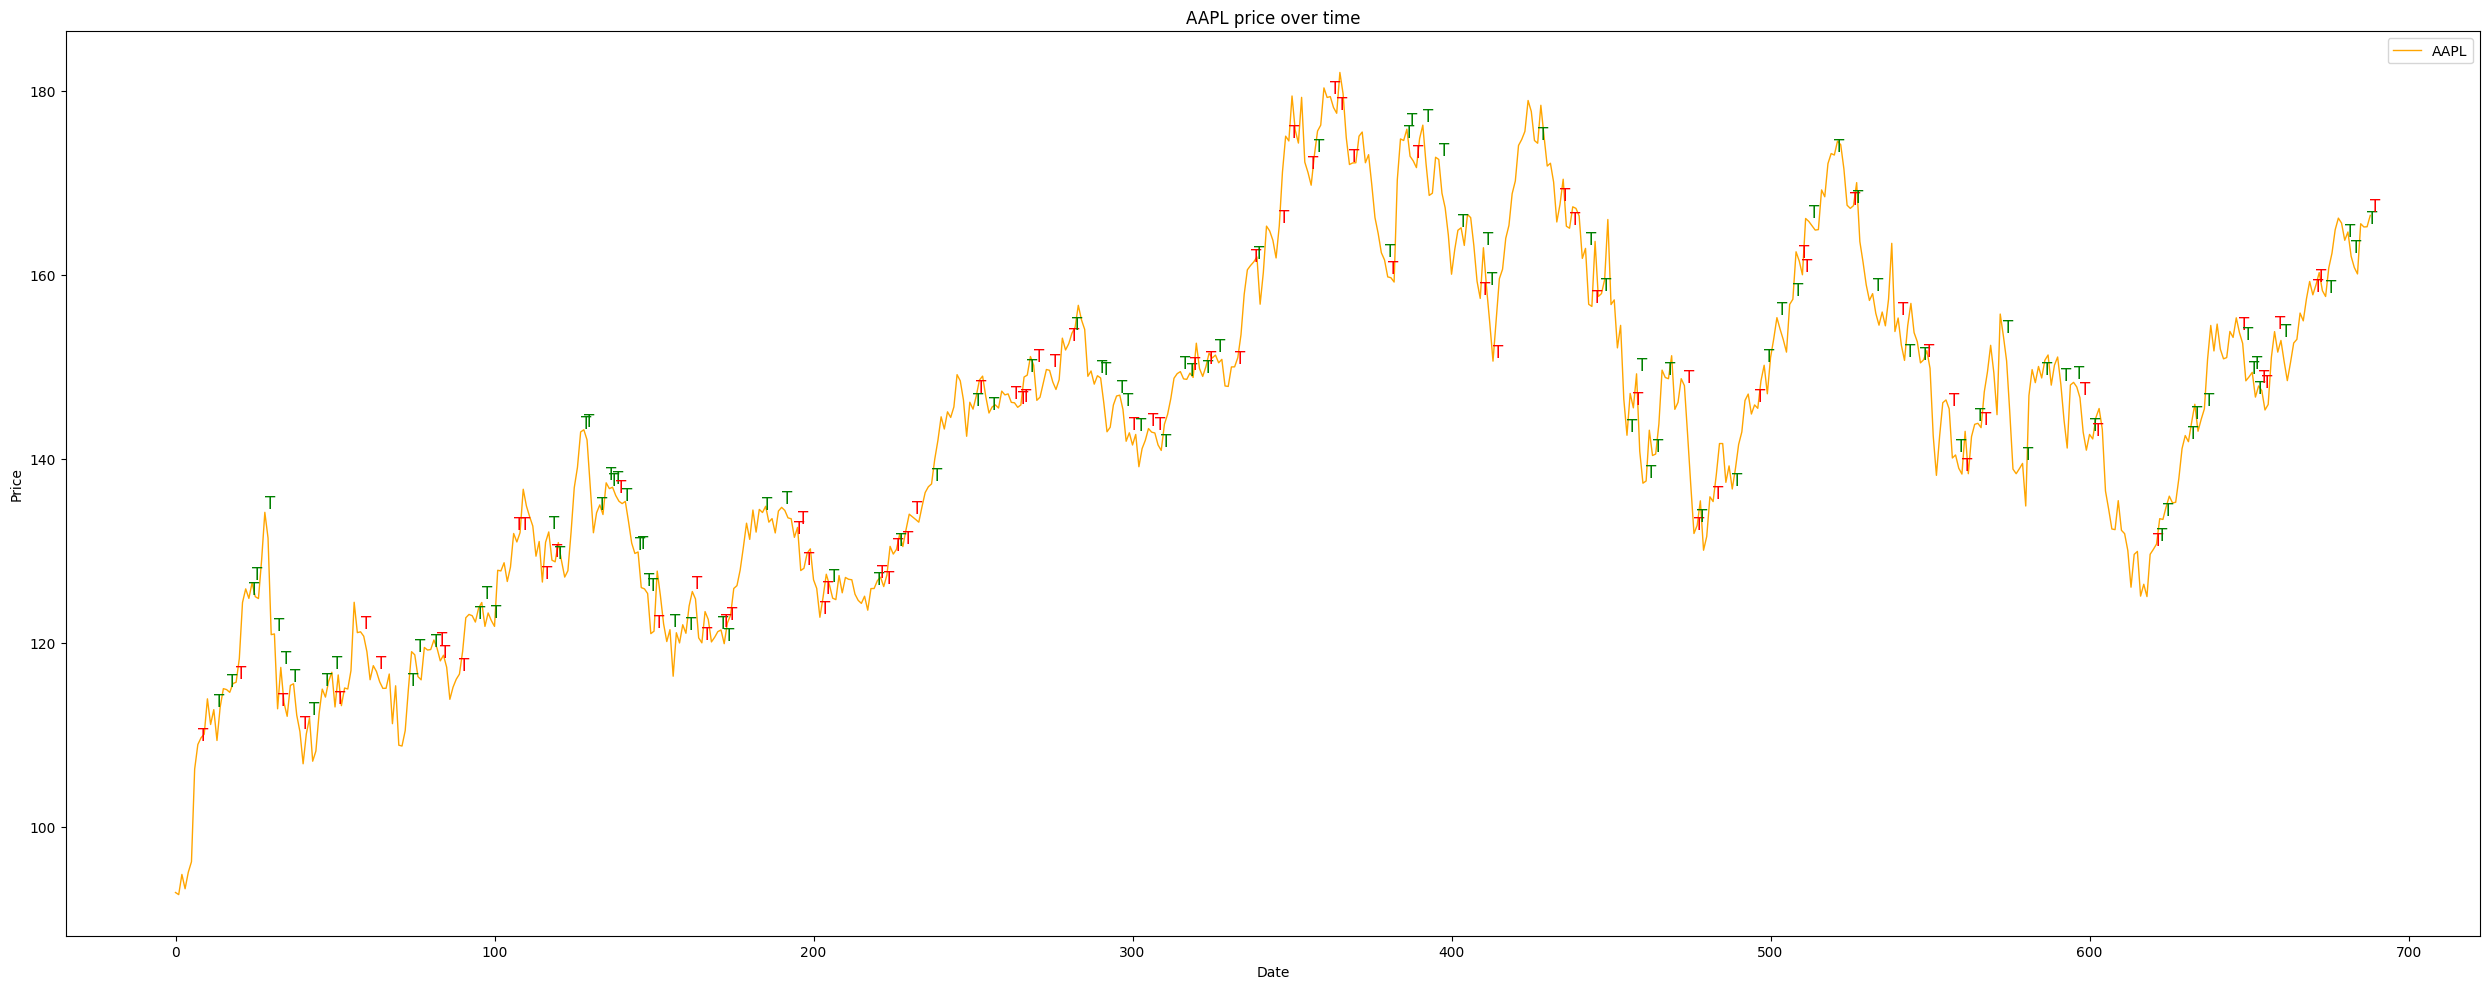

In [26]:
# Create a list of pattern functions to pass to the plot_patterns function
pattern_funcs = [Tail]

# Call the plot_patterns function
plot_patterns(df, pattern_funcs, params)

##### Harami :
It is a two-bar pattern where an inside bar follows a wide range bar, and the inside bar closes in the opposite direction.
It signals a reversal.

In [27]:
def Harami(stock_data, window_size, time_period):
    harami = []
    for i in range(len(stock_data)):
        current_bar = stock_data.iloc[i]
        previous_bar = stock_data.iloc[i-1]
        if (current_bar["Open"] > previous_bar["Close"]) and (current_bar["Close"] < previous_bar["Open"]):
            harami.append(1)
        else:
            harami.append(0)
    return harami

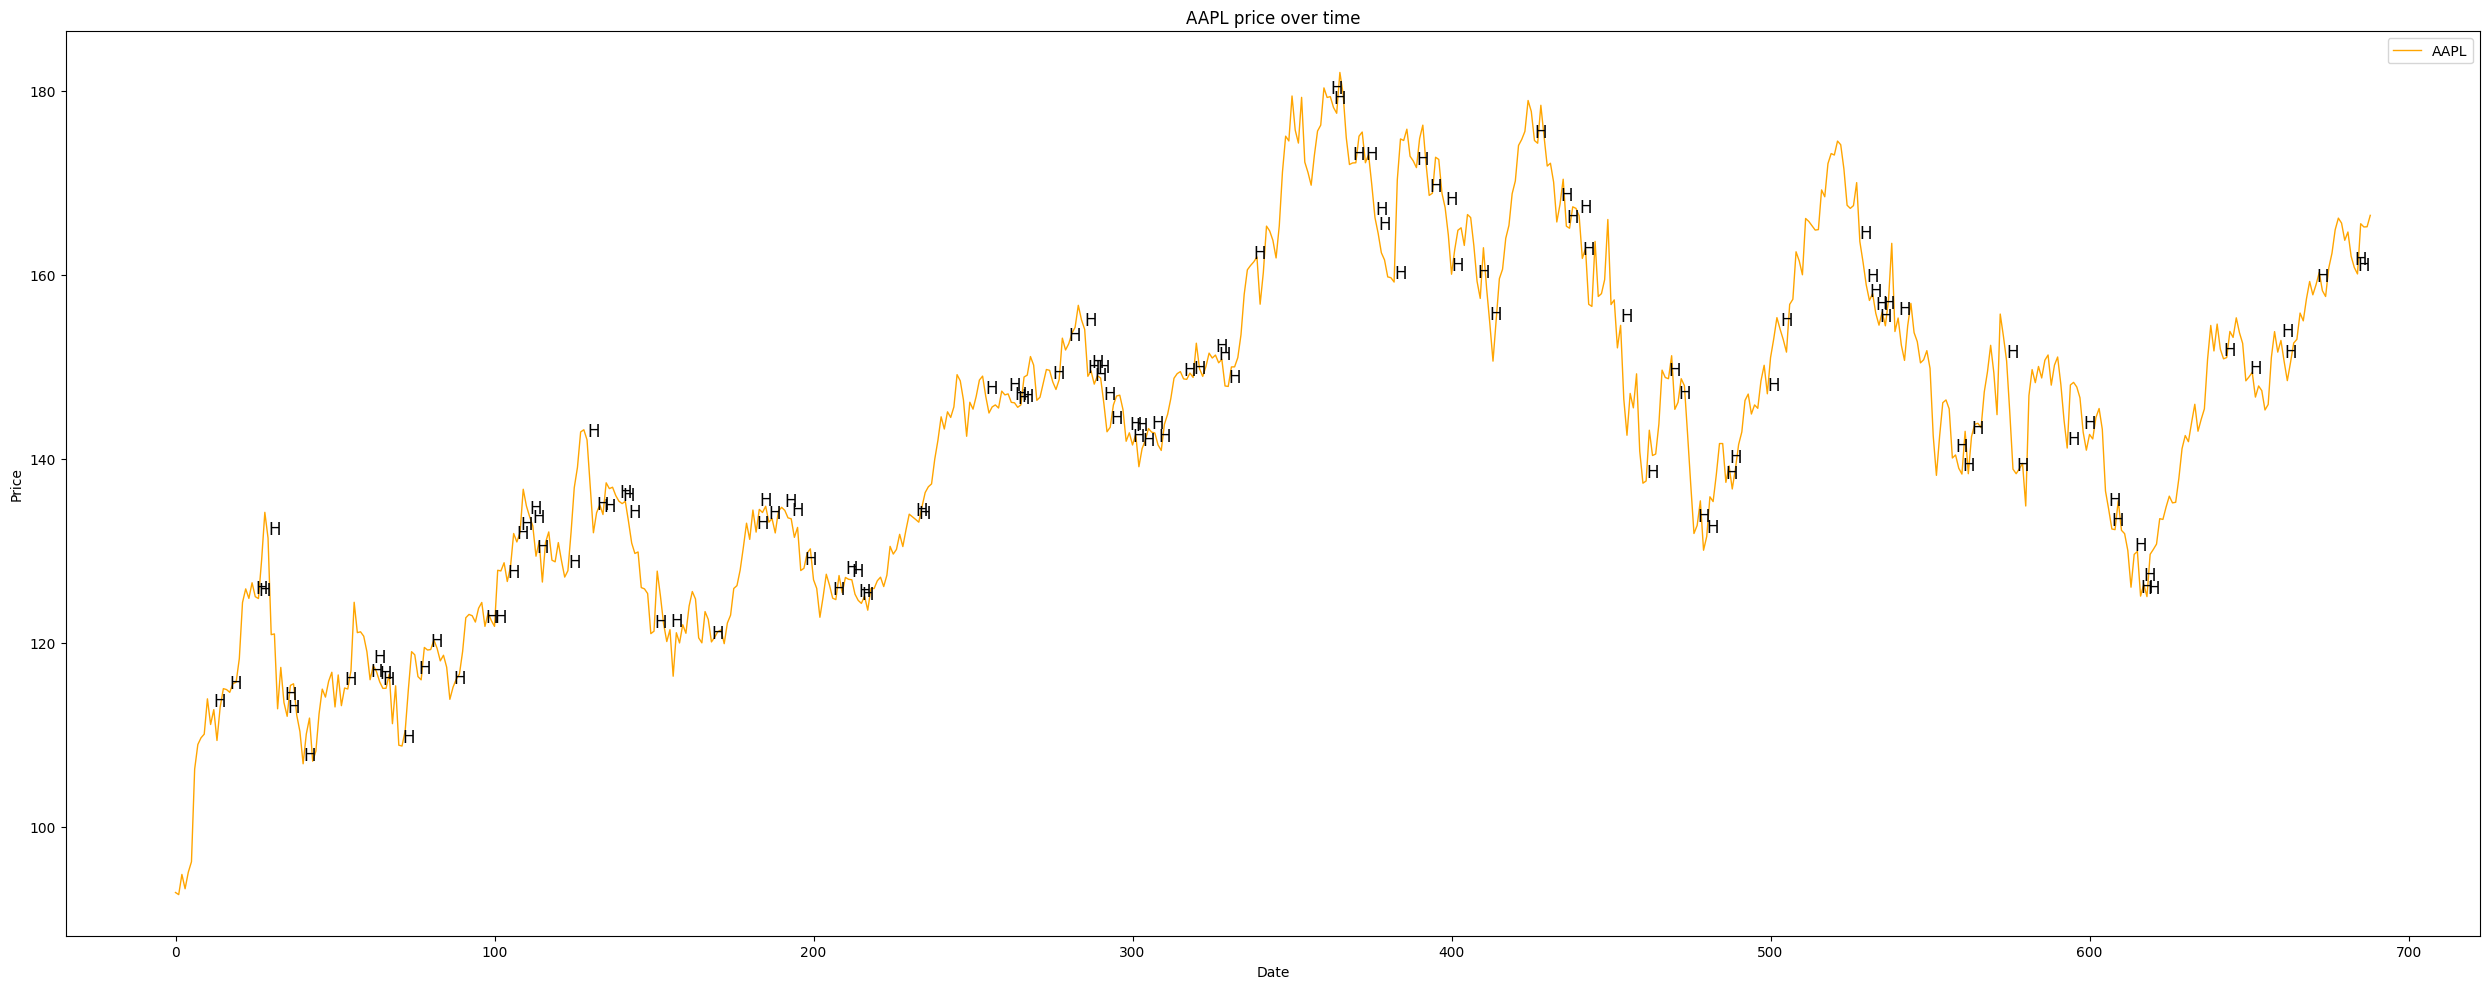

In [28]:
# Create a list of pattern functions to pass to the plot_patterns function
pattern_funcs = [Harami]

# Call the plot_patterns function
plot_patterns(df, pattern_funcs, params)

##### Test:
In a bullish test, the bar breaks below a previous low (support), and closes in the top half of this range. 

In a bearish Test, the Test bar exceeds a previous high (resistance) and closes in the bottom half of its range 

In [29]:
def Test(stock_data, window_size, time_period):
    test = []
    for i in range(len(stock_data)):
        current_bar = stock_data.iloc[i]
        previous_bar = stock_data.iloc[i-1]
        # check if current bar broke previous low
        if current_bar["Low"] < previous_bar["Low"]:
            if (current_bar["Close"] - current_bar["Low"]) >= (current_bar["High"] - current_bar["Low"])/2:
                test.append(+1)
            else:
                test.append(0)
        # check if current bar exceeded previous high
        elif current_bar["High"] > previous_bar["High"]:
            if (current_bar["High"] - current_bar["Close"]) > (current_bar["High"] - current_bar["Low"])/2:
                test.append(-1)
            else: 
                test.append(0)
        else:
            test.append(0)
    return test

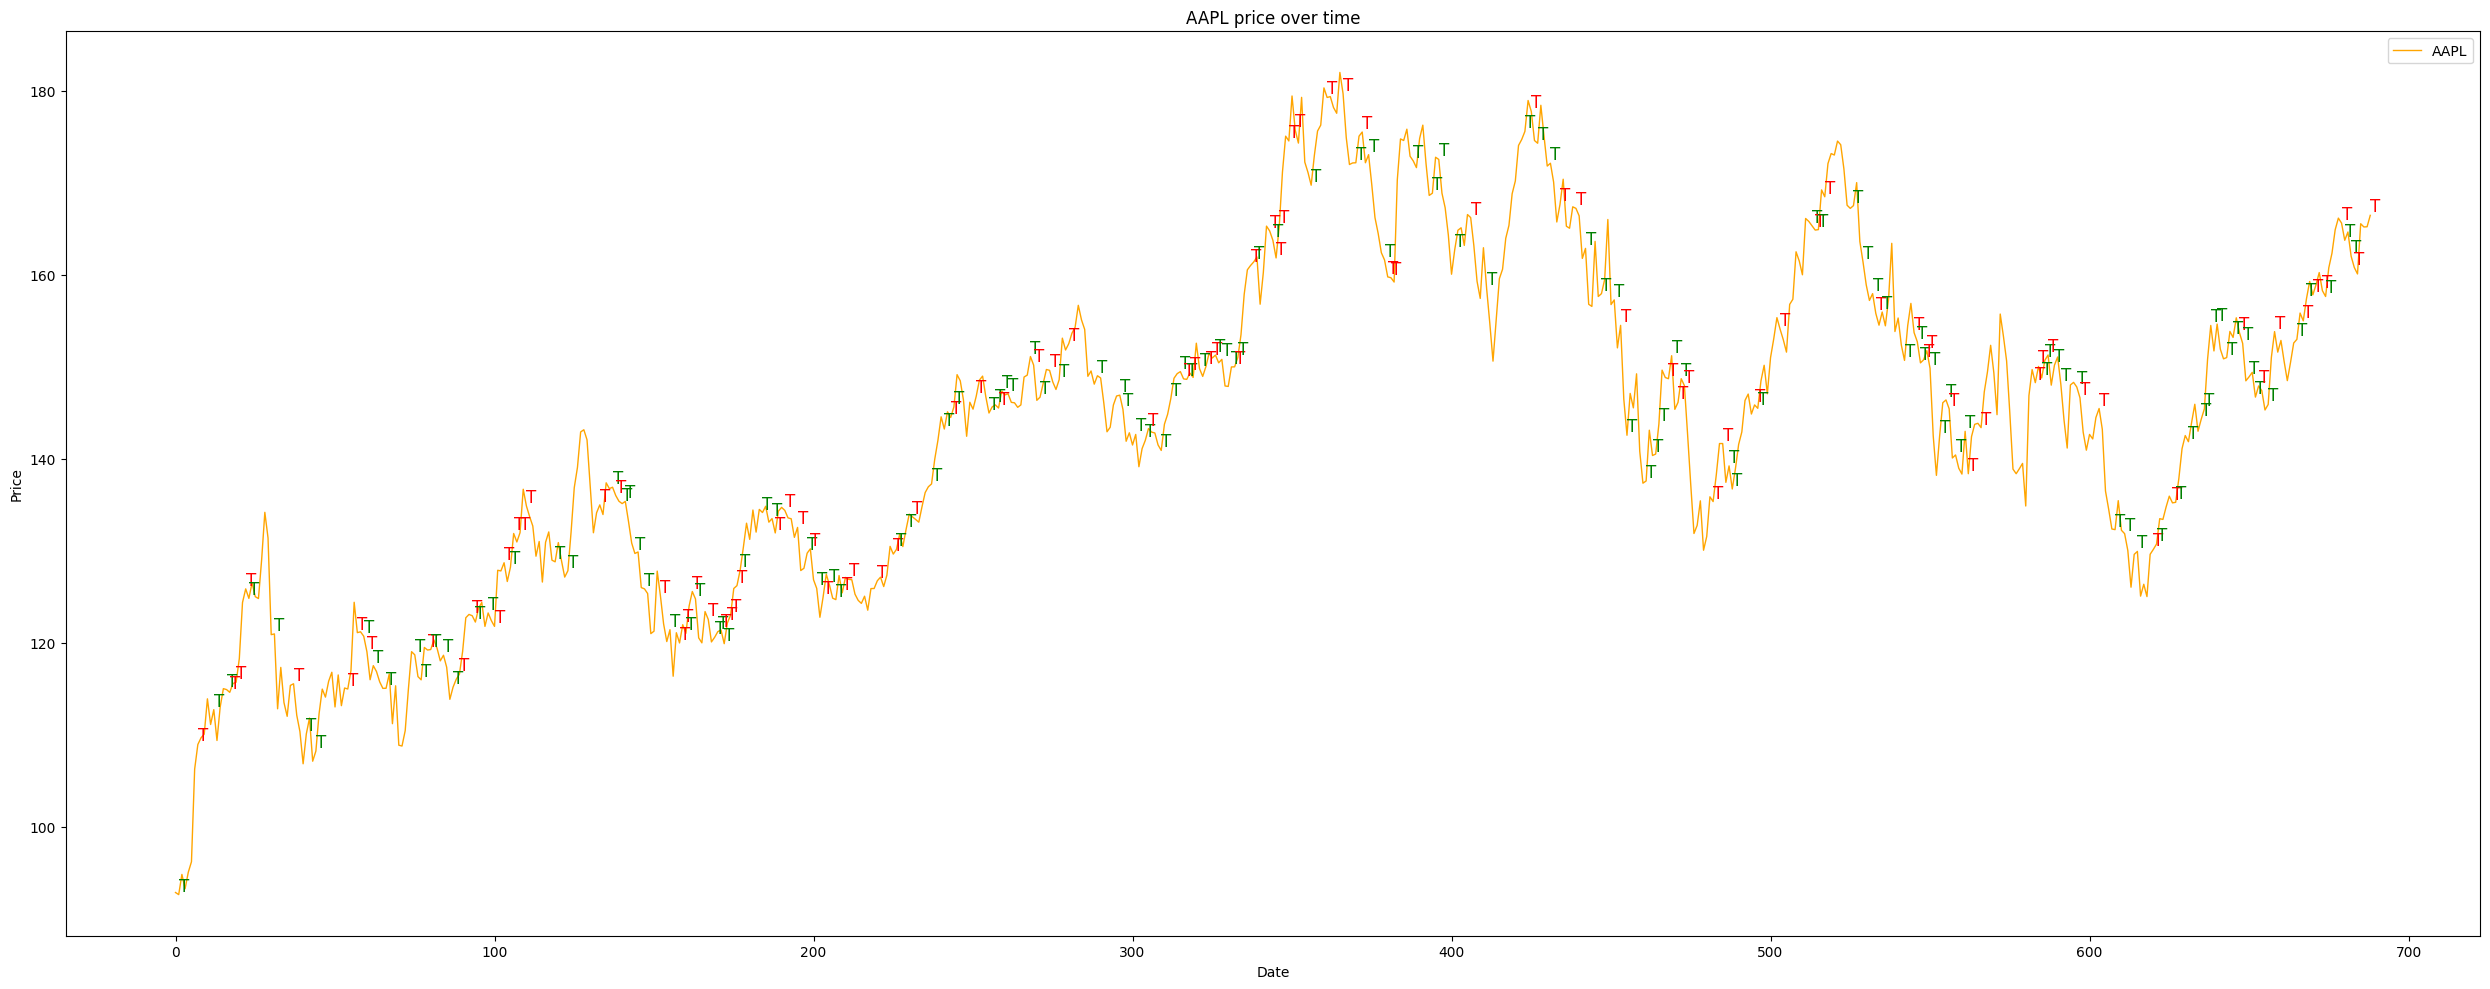

In [30]:
# Create a list of pattern functions to pass to the plot_patterns function
pattern_funcs = [Test]

# Call the plot_patterns function
plot_patterns(df, pattern_funcs, params)

##### Pullback :
A bullish pullback occurs when the trend is up, and price makes a certain number of lower lows or a combination of lower lows and inside days

A bearish pullback occurs when the trend is down, and price makes a certain number of higher highs or a combination of higher highs and inside days.

In [31]:
def Pullback(stock_data, window_size=6, time_period=1):
    pullback = []
    trend_data = calculate_trend(stock_data, window_size)
    for i in range(len(stock_data)):
        if trend_data[i] == "Up":
            if check_for_lower_lows(stock_data, i, time_period):
                pullback.append(1)
            else:
                pullback.append(0)
        elif trend_data[i] == "Down":
            if check_for_higher_highs(stock_data, i, time_period):
                pullback.append(-1)
            else:
                pullback.append(0)
        else:
            pullback.append(0)
    return pullback

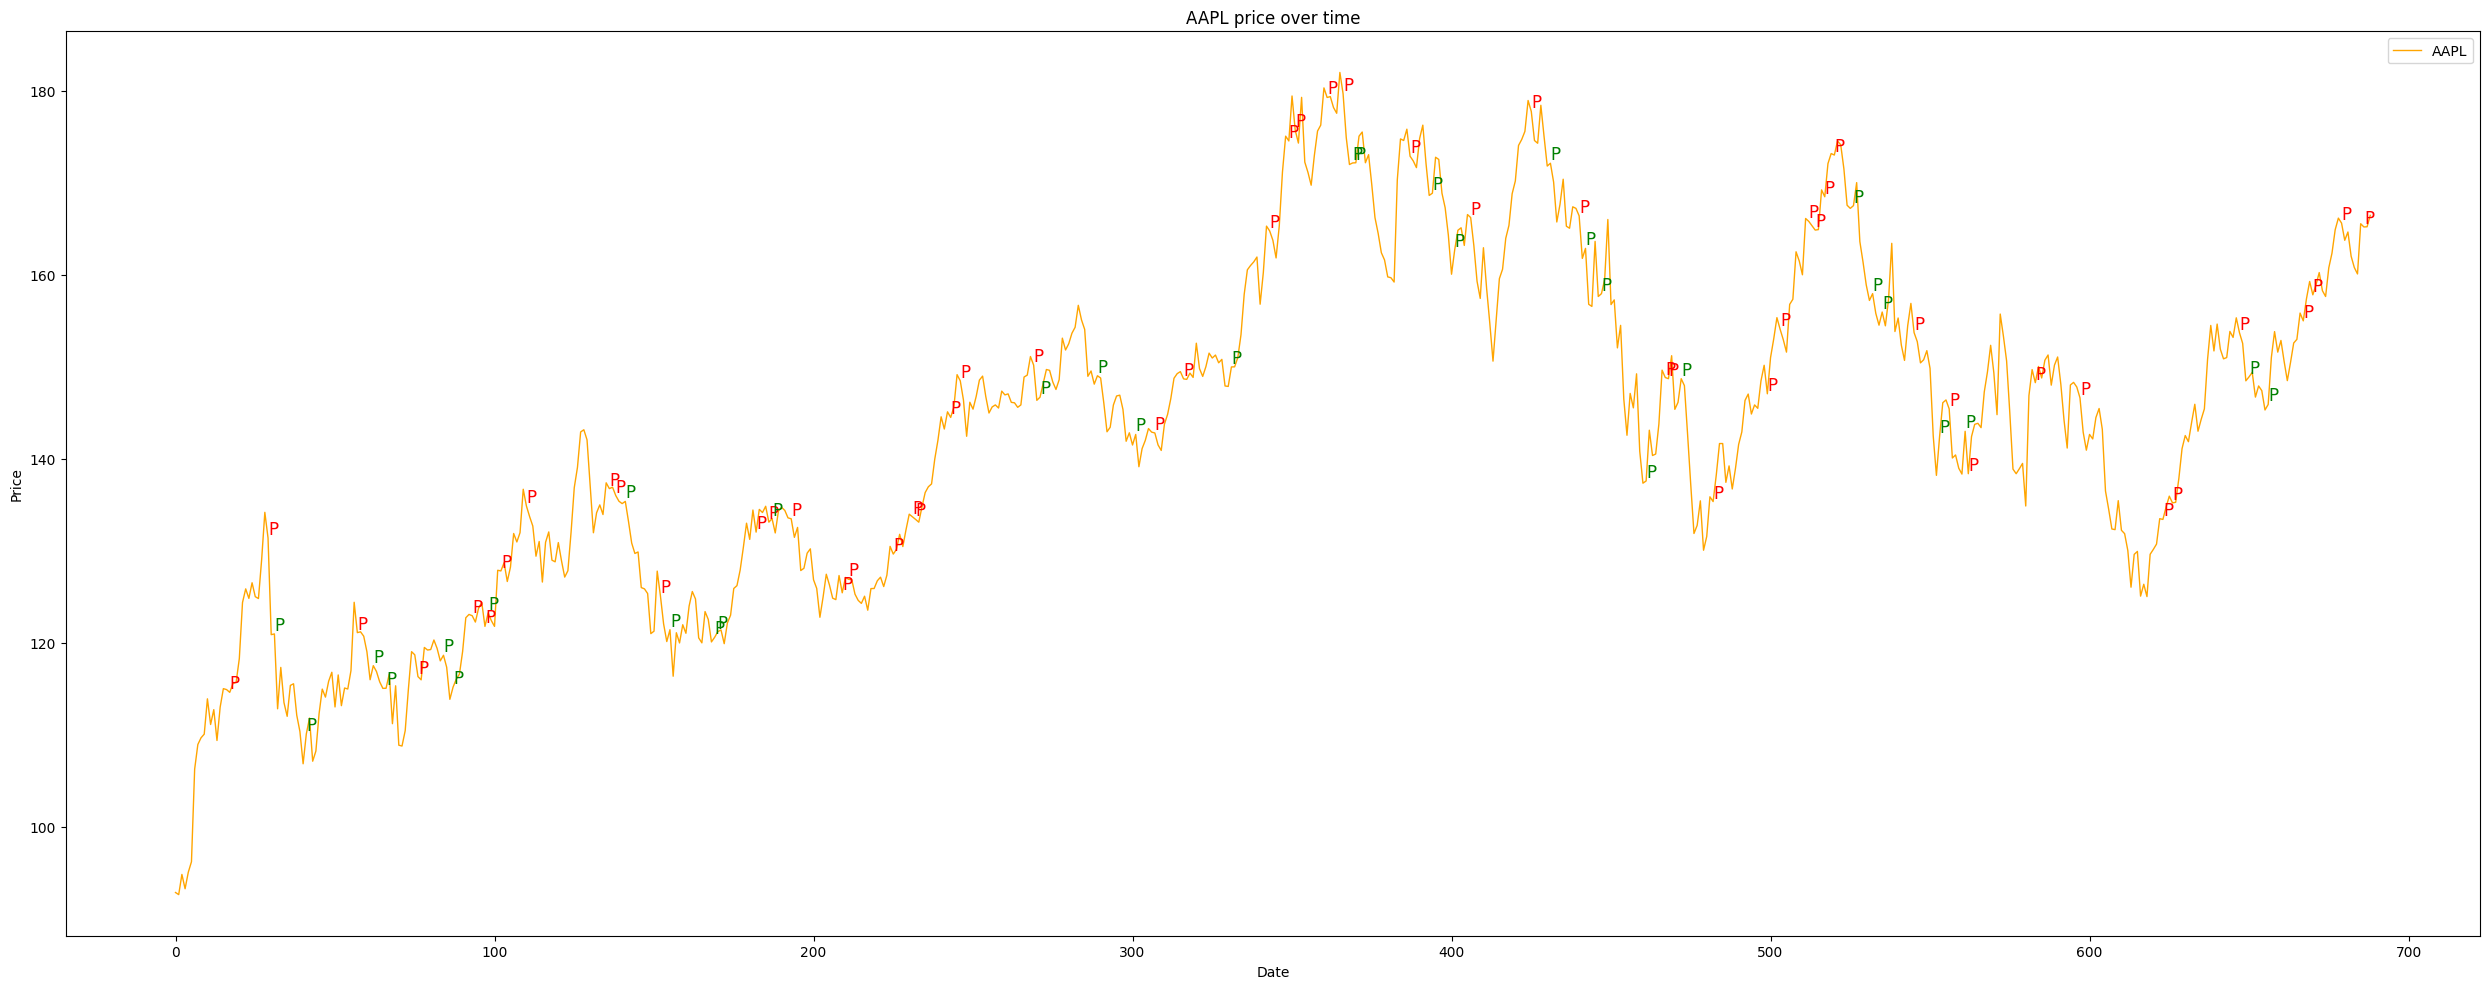

In [32]:
# Create a list of pattern functions to pass to the plot_patterns function
pattern_funcs = [Pullback]

# Call the plot_patterns function
plot_patterns(df, pattern_funcs, params)

##### VZone:
Pattern where the market breaks through a resistance/support level, then quickly pulls back and then moves in the direction of the breakout again. It's called a V-zone because it looks like a letter V on the chart.

In [33]:
def Vzone(stock_data, window_size=5, time_period=5):
    vzone = [0] * len(stock_data)
    level=0.01
    support, resistance = calculate_support_resistance(stock_data, window_size)
    for i in range(time_period,len(stock_data)):
        current_close = stock_data.iloc[i]['Close']
        previous_close = stock_data.iloc[i-time_period]['Close']
        if current_close > support[i] and (current_close - previous_close)/previous_close > level:
            vzone[i]=1
        elif current_close < resistance[i] and (previous_close - current_close)/previous_close > level:
            vzone[i]=-1
        else:
            vzone[i]=0
    return vzone

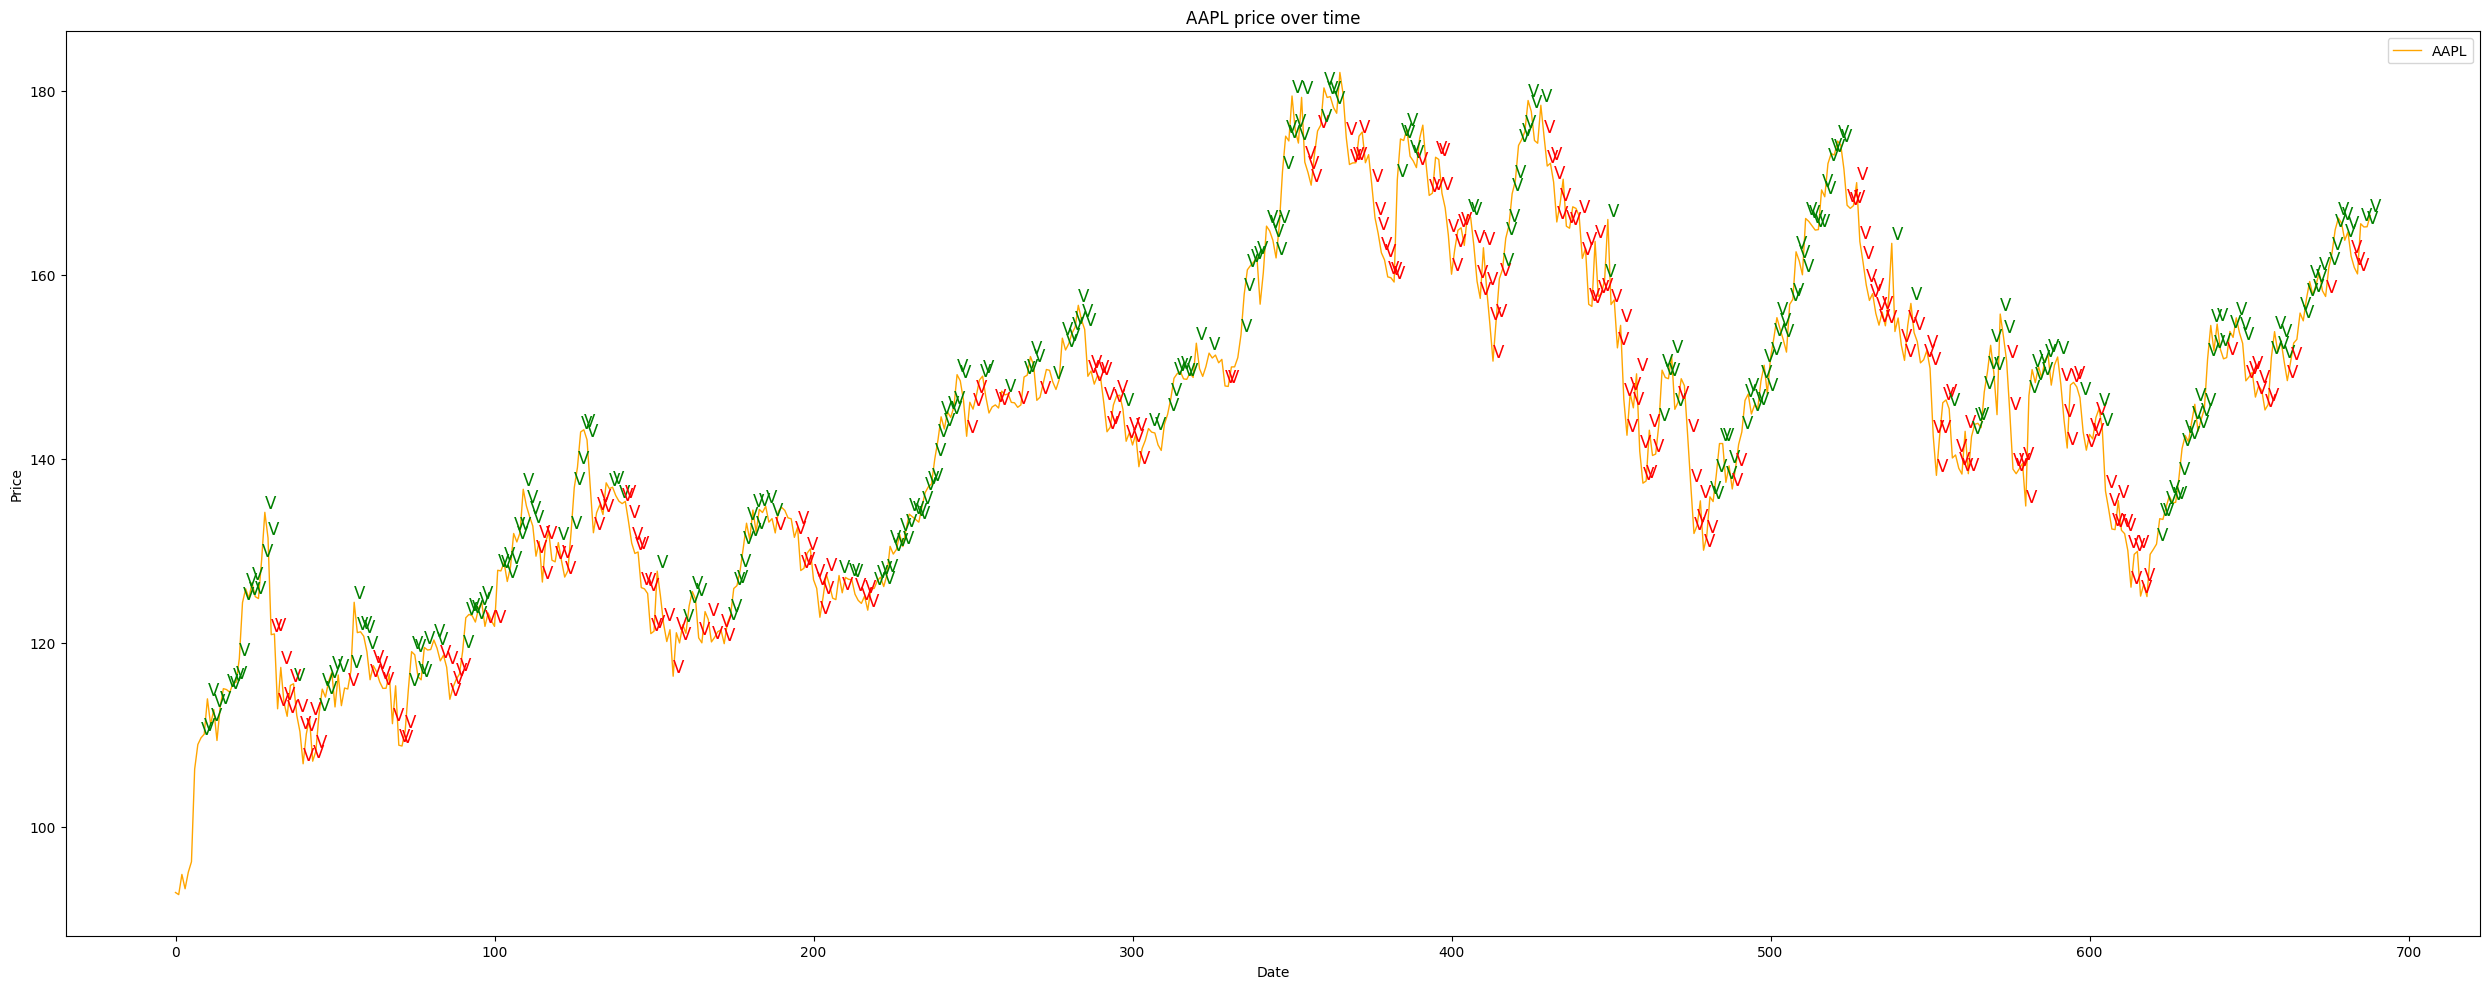

In [34]:
# Create a list of pattern functions to pass to the plot_patterns function
pattern_funcs = [Vzone]

# Call the plot_patterns function
plot_patterns(df, pattern_funcs, params)

##### Doji :
A doji is a name for a trading session in which a security has open and close levels that are virtually equal.
It is a reversal indication.

In [35]:
def Doji(stock_data,window_size, time_period):
    doji_candles=[]
    for i in range(len(stock_data)):
        # Calculate the difference between open and close price
        diff=abs(stock_data.iloc[i]['Open']-stock_data.iloc[i]['Close'])
        # Check if the difference is less than or equal to 1% of the open price
        if diff<=(stock_data.iloc[i]['Open']*0.01):
            doji_candles.append(1)
        else:
            doji_candles.append(0)
    return doji_candles

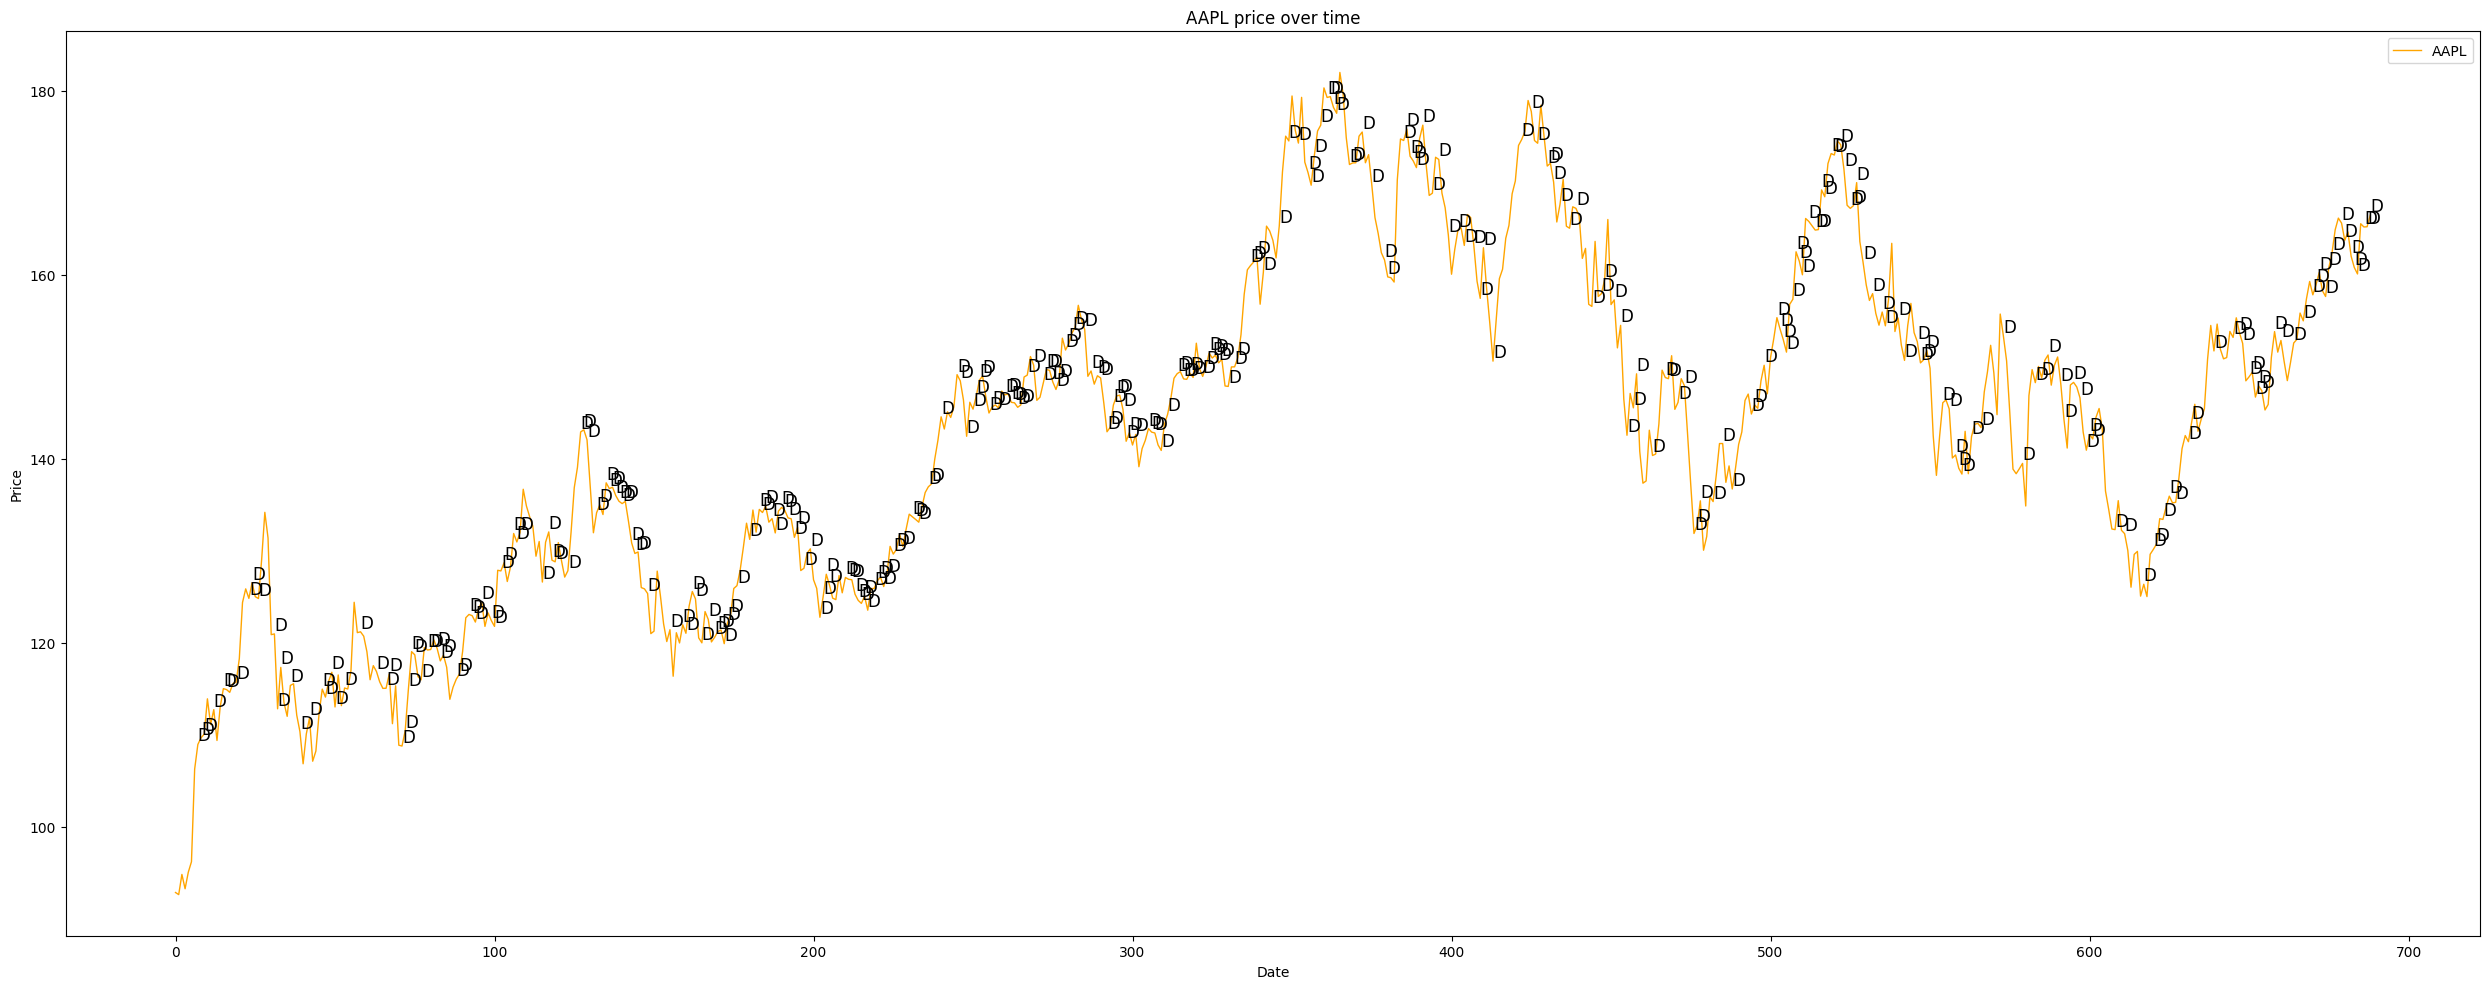

In [36]:
# Create a list of pattern functions to pass to the plot_patterns function
pattern_funcs = [Doji]

# Call the plot_patterns function
plot_patterns(df, pattern_funcs, params)

##### Hammer :
A hammer is a price pattern that occurs when a security trades significantly lower than its opening, but rallies within the period to close near the opening price.
Hammer candlesticks indicate a potential price reversal to the upside.

In [37]:
def Hammer(stock_data,window_size, time_period):
    hammer_candles=[]
    for i in range(len(stock_data)):
        body=min(stock_data.iloc[i]['Open'],stock_data.iloc[i]['Close'])-stock_data.iloc[i]['Low']
        tail=stock_data.iloc[i]['High']-max(stock_data.iloc[i]['Open'],stock_data.iloc[i]['Close'])
        # Check if the tail is at least twice as long as the body
        if tail>=(body*2) and body<=(stock_data.iloc[i]['Open']*0.01):
            hammer_candles.append(1)
        else:
            hammer_candles.append(0)
    return hammer_candles

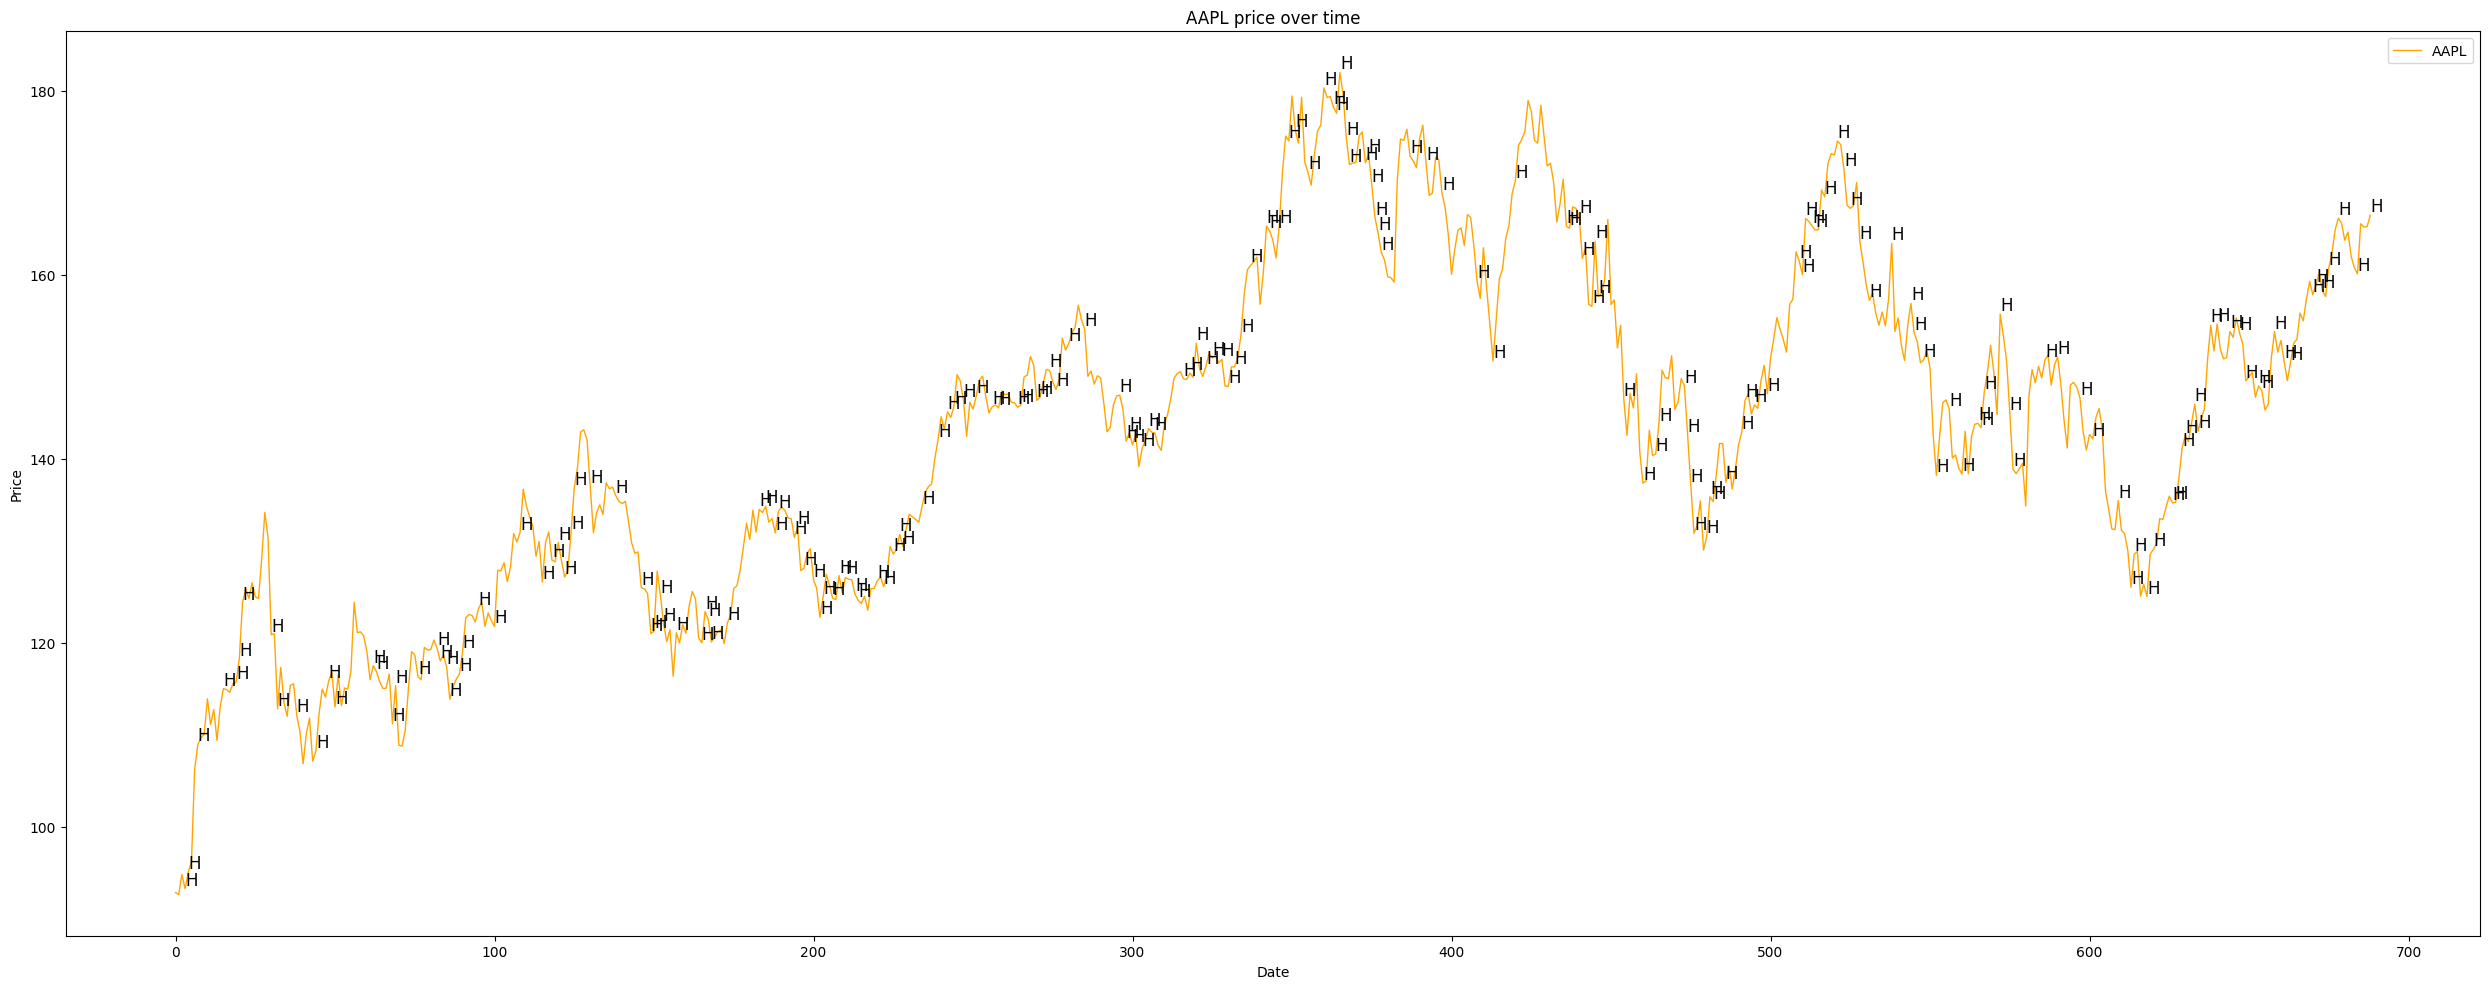

In [38]:
# Create a list of pattern functions to pass to the plot_patterns function
pattern_funcs = [Hammer]

# Call the plot_patterns function
plot_patterns(df, pattern_funcs, params)

##### Volume :

In [39]:
# Affichage du volume total
volume_total=df["Volume"].sum()
print("Volume total: ",volume_total)

# Affichage du volume moyen par jour
volume_moyen_jour=df["Volume"].mean()
print("Volume moyen par jour: ",volume_moyen_jour)

Volume total:  66225680142
Volume moyen par jour:  96118548.82728592


##### Volume Climax Pattern : 
This pattern occurs when there is a sharp increase/decrease in volume, accompanied by a bullish/bearish candle or trend. It's often considered a sign of buying/selling pressure and a potential bullish/bearish reversal

In [40]:
def Volume_Climax(stock_data, window_size, time_period):
    pattern = [0] * len(stock_data)
    for i in range(1,len(stock_data)):
        if stock_data.iloc[i]['Volume'] > stock_data.iloc[i-1]['Volume']:
            if stock_data.iloc[i]['Close'] > stock_data.iloc[i-1]['Close']:
                pattern[i]=1
            elif stock_data.iloc[i]['Close'] < stock_data.iloc[i-1]['Close']:
                pattern[i]=-1
            else:
                pattern[i]=0
        else:
            pattern[i]=0
    return pattern

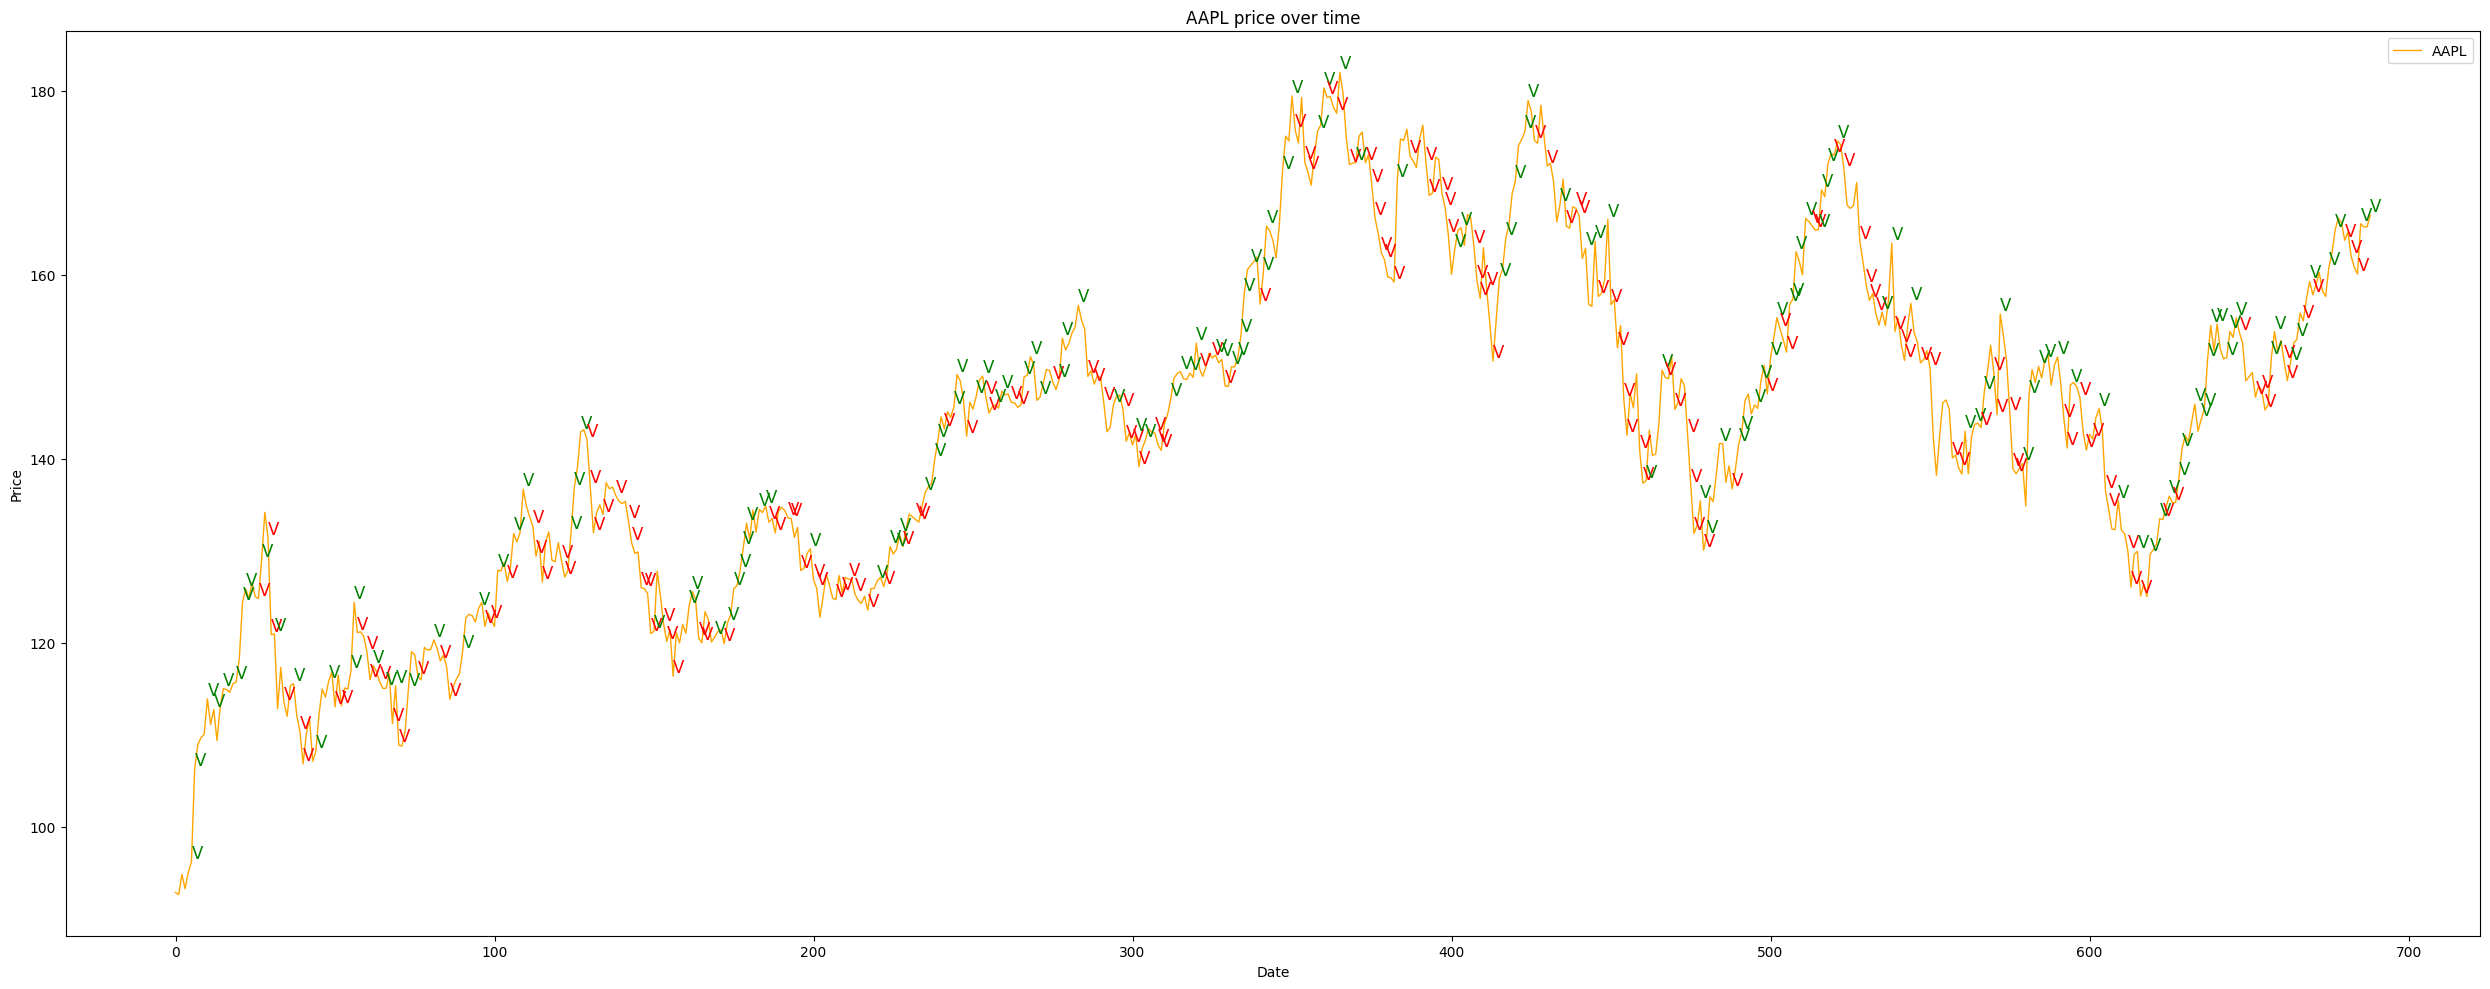

In [41]:
# Create a list of pattern functions to pass to the plot_patterns function
pattern_funcs = [Volume_Climax]

# Call the plot_patterns function
plot_patterns(df, pattern_funcs, params)

##### On-Balance Volume Pattern (OBV): 
This pattern tracks the cumulative volume of a stock to determine its trend. 

The OBV indicator adds the total volume of an asset to a running total when the price closes higher, and subtracts the total volume of an asset when the price closes lower.

It takes in stock data, window size, and time period as inputs, and returns a binary output 

In [42]:
def OBV(stock_data, window_size, time_period):
    obv = [0] * len(stock_data)
    output = [0] * len(stock_data)
    for i in range(1, len(stock_data)):
        if i < window_size:
            obv[i] = 0
        else:
            prev_close = stock_data.iloc[i-window_size]['Close']
            curr_close = stock_data.iloc[i]['Close']
            if curr_close > prev_close:
                obv[i] = obv[i-1] + stock_data.iloc[i]['Volume']
            elif curr_close < prev_close:
                obv[i] = obv[i-1] - stock_data.iloc[i]['Volume']
            else:
                obv[i] = obv[i-1]
        if i >= window_size + time_period:
            obv_diff = obv[i] - obv[i-time_period]
            if obv_diff > 0:
                output[i] = 1
            elif obv_diff < 0:
                output[i] = -1
            else:
                output[i] = 0
    return output

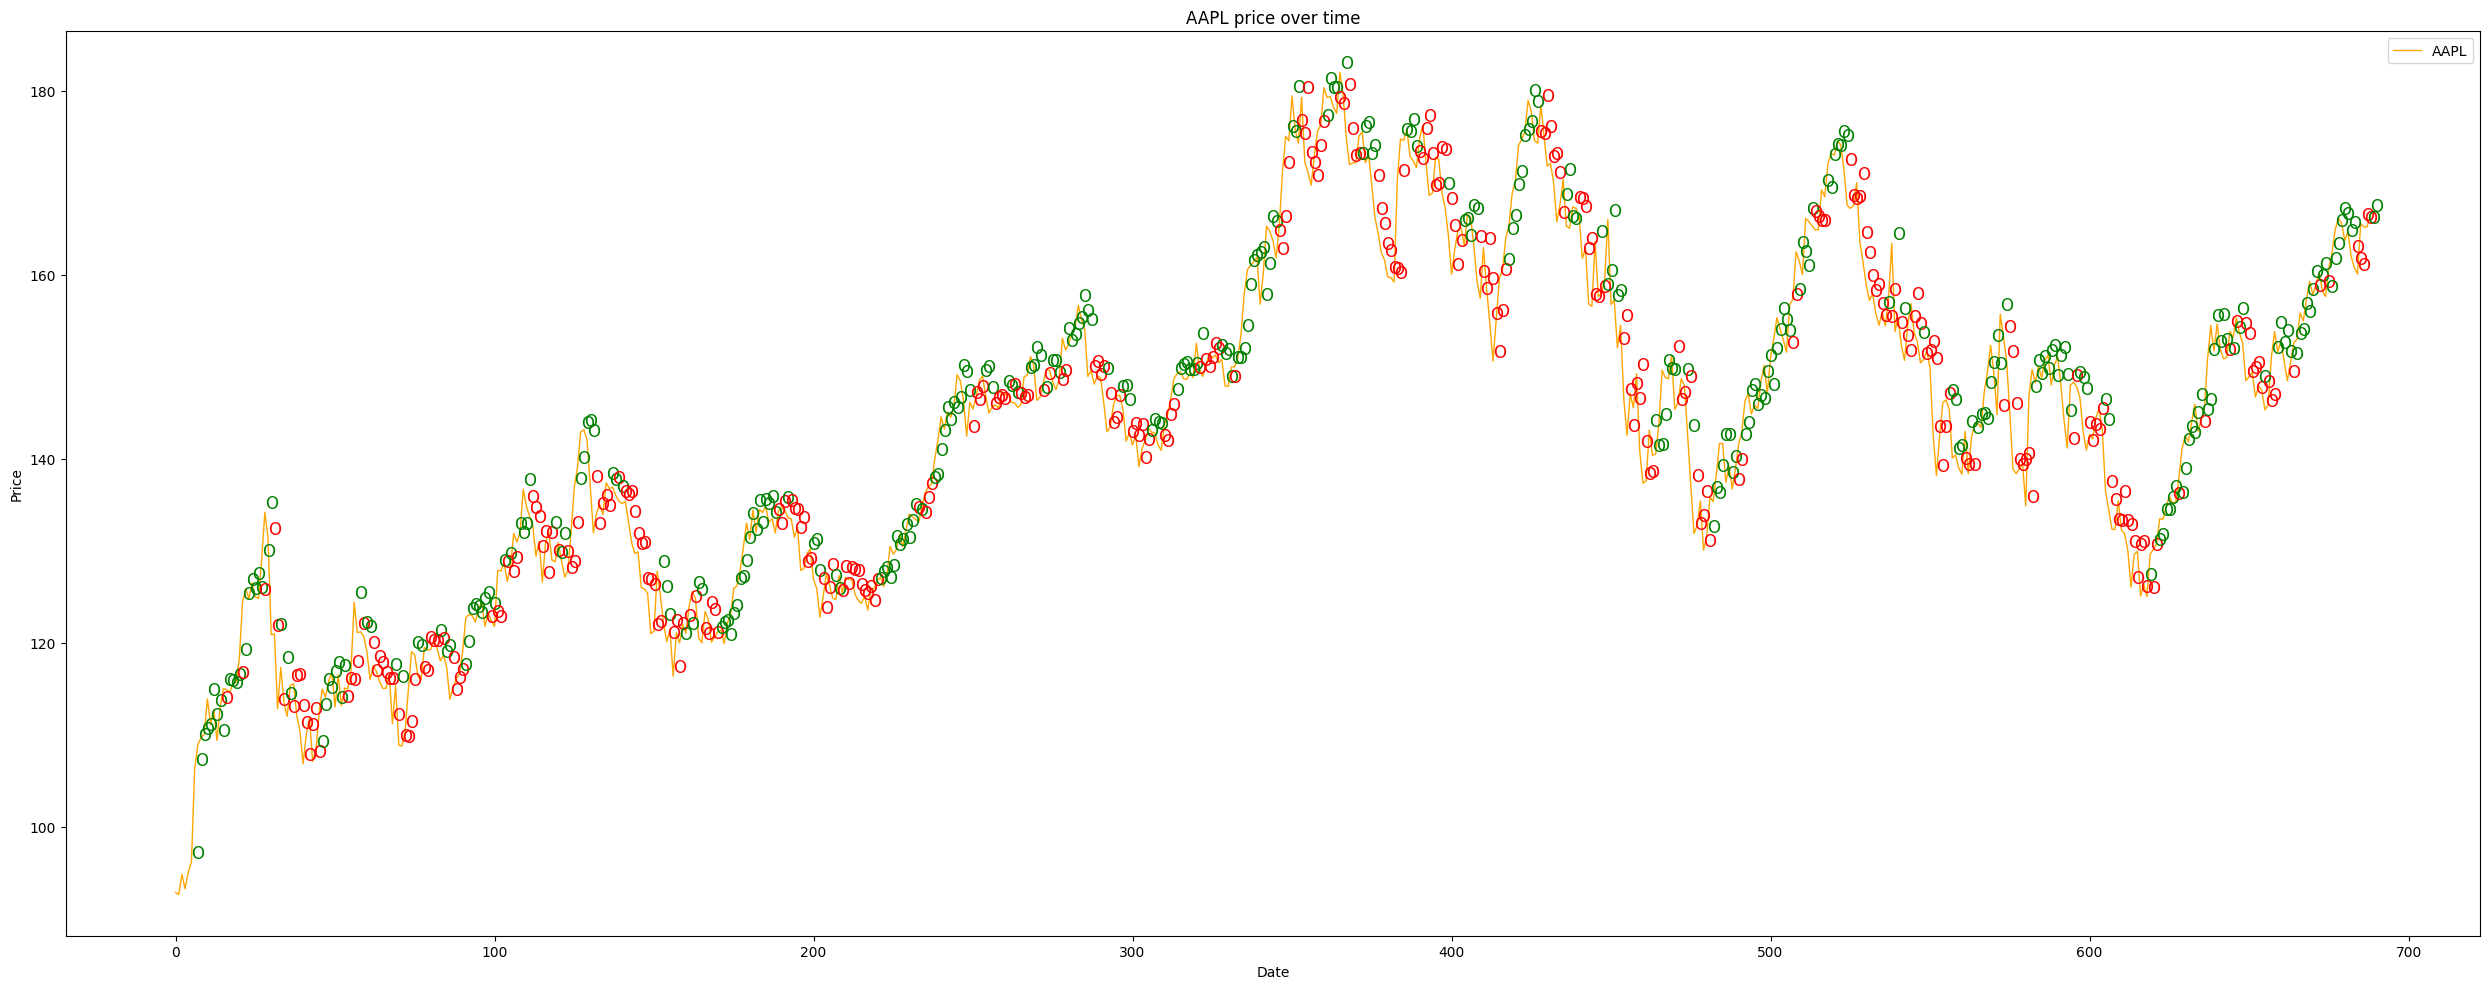

In [43]:
# Create a list of pattern functions to pass to the plot_patterns function
pattern_funcs = [OBV]

# Call the plot_patterns function
plot_patterns(df, pattern_funcs, params)

##### Trend: 

In [44]:
# Calcul de la différence de prix entre chaque jour
df["diff_prix"]=df["Close"].diff()

# Détection d'un trend à la hausse si la différence de prix est positive sur au moins 5 jours consécutifs
trend_hausse=False
if(df["diff_prix"]>0).sum()>=5:
    trend_hausse=True

# Détection d'un trend à la baisse si la différence de prix est négative sur au moins 5 jours consécutifs
trend_baisse=False
if(df["diff_prix"]<0).sum()>=5:
    trend_baisse=True

# Affichage du résultat
if trend_hausse:
    print("Trend à la hausse détecté")
elif trend_baisse:
    print("Trend à la baisse détecté")
else:
    print("Aucun trend détecté")

Trend à la hausse détecté


##### Mean Reversion :

Mean reversion pattern is used to identify potential trend reversals. If the price of an asset moves too far away from its mean, it will eventually return to its mean. The pattern is be bullish if the price is moving up after a long period of decline and is bearish if the price is moving down after a long period of growth

In [45]:
def MeanReversion(df, window_size, time_period):
    rolling_mean = df['Close'].rolling(window=window_size).mean()
    rolling_std = df['Close'].rolling(window=window_size).std()

    upper_band = rolling_mean + rolling_std
    lower_band = rolling_mean - rolling_std

    signal = []
    for i in range(len(df)):
        if i >= time_period:
            if df.iloc[i]['Close'] <= lower_band.iloc[i-1]:
                if df.iloc[i]['Close'] > lower_band.iloc[i]:
                    signal.append(1)
                else:
                    signal.append(0)
            elif df.iloc[i]['Close'] >= upper_band.iloc[i-1]:
                if df.iloc[i]['Close'] < upper_band.iloc[i]:
                    signal.append(-1)
                else:
                    signal.append(0)
            else:
                signal.append(0)
        else:
            signal.append(0)
    return signal

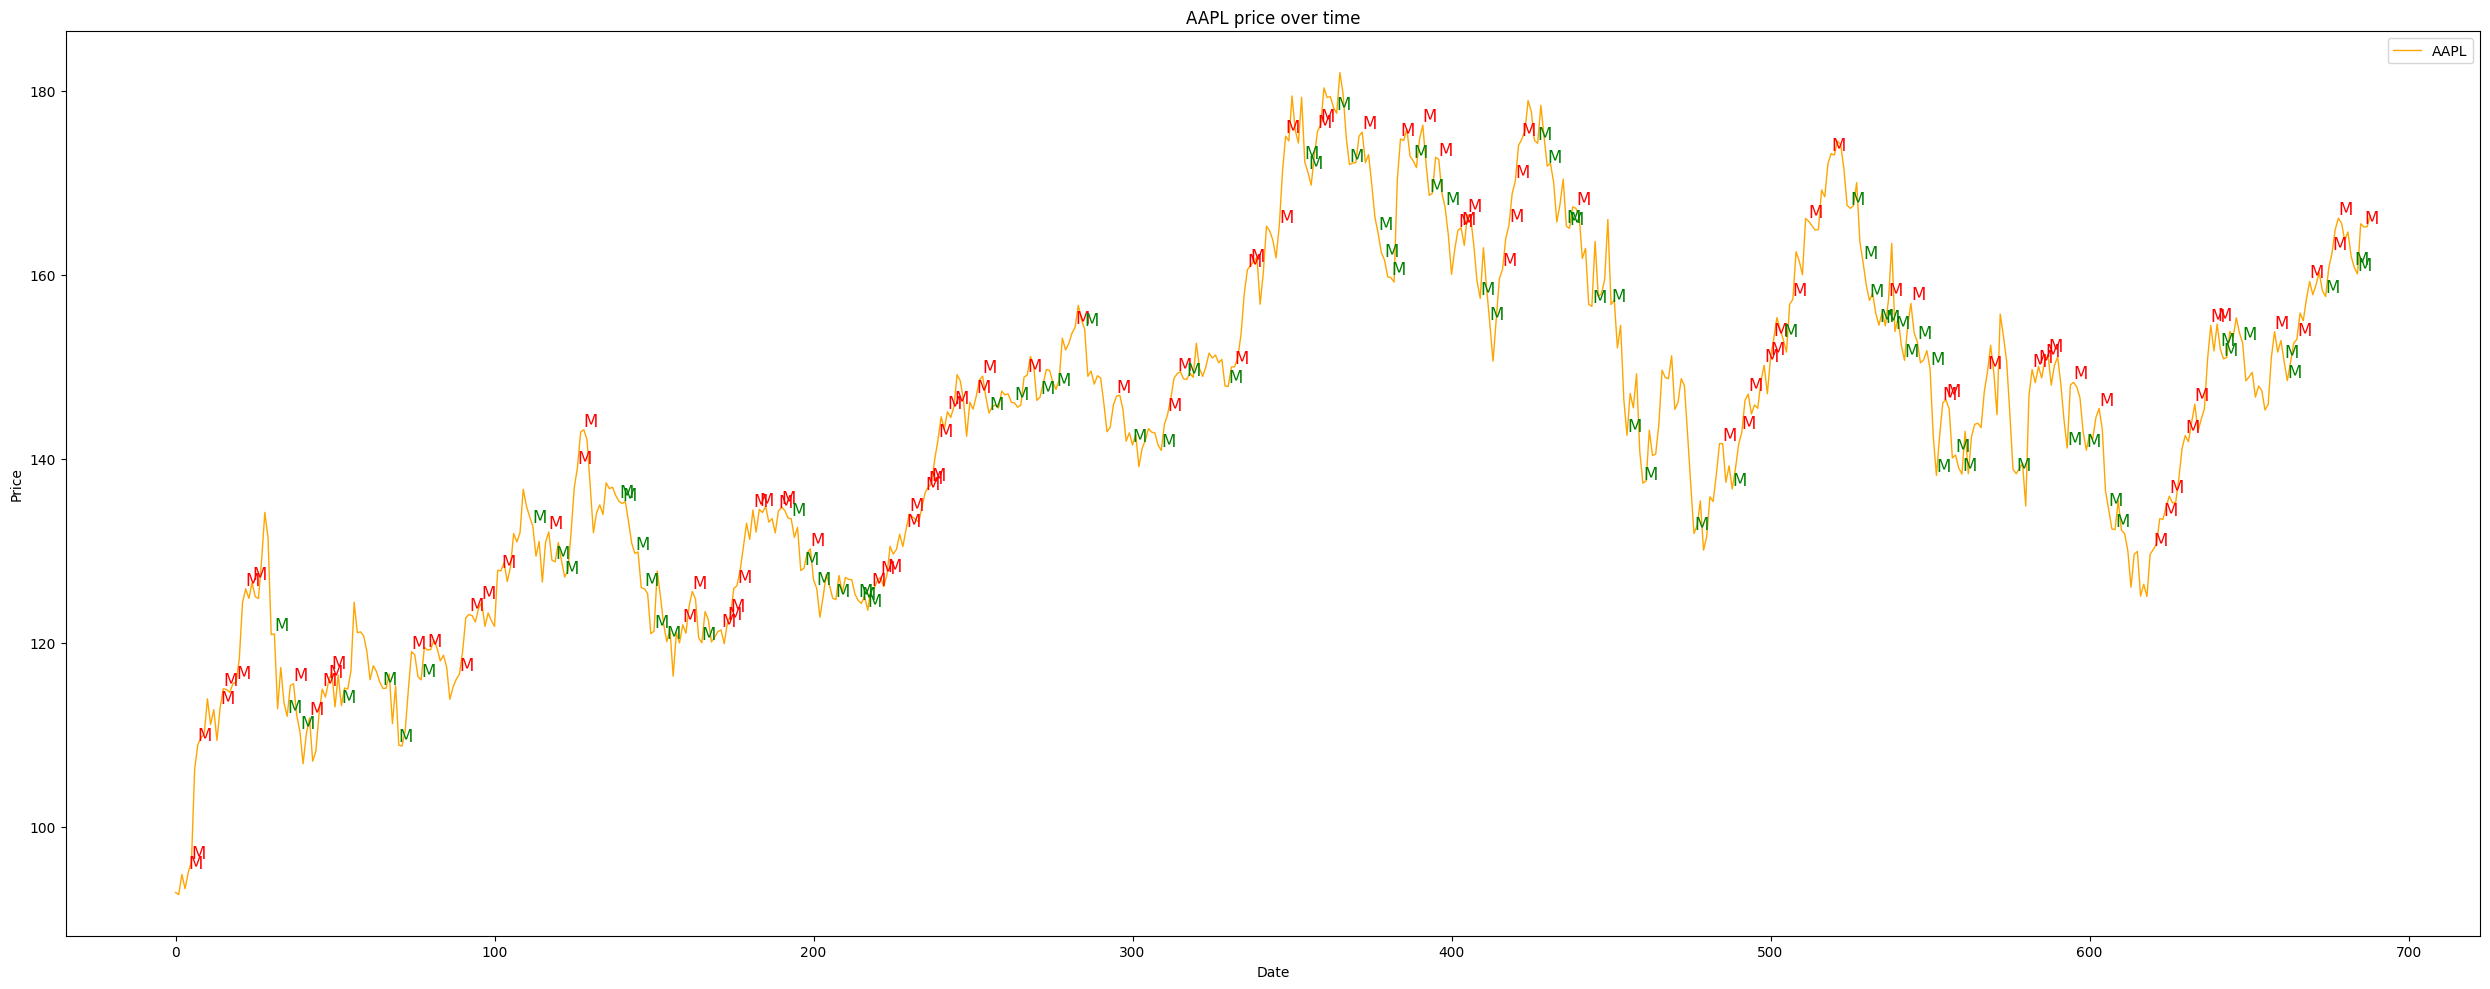

In [46]:
# Create a list of pattern functions to pass to the plot_patterns function
pattern_funcs = [MeanReversion]

# Call the plot_patterns function
plot_patterns(df, pattern_funcs, params)

#### Display of all the patterns

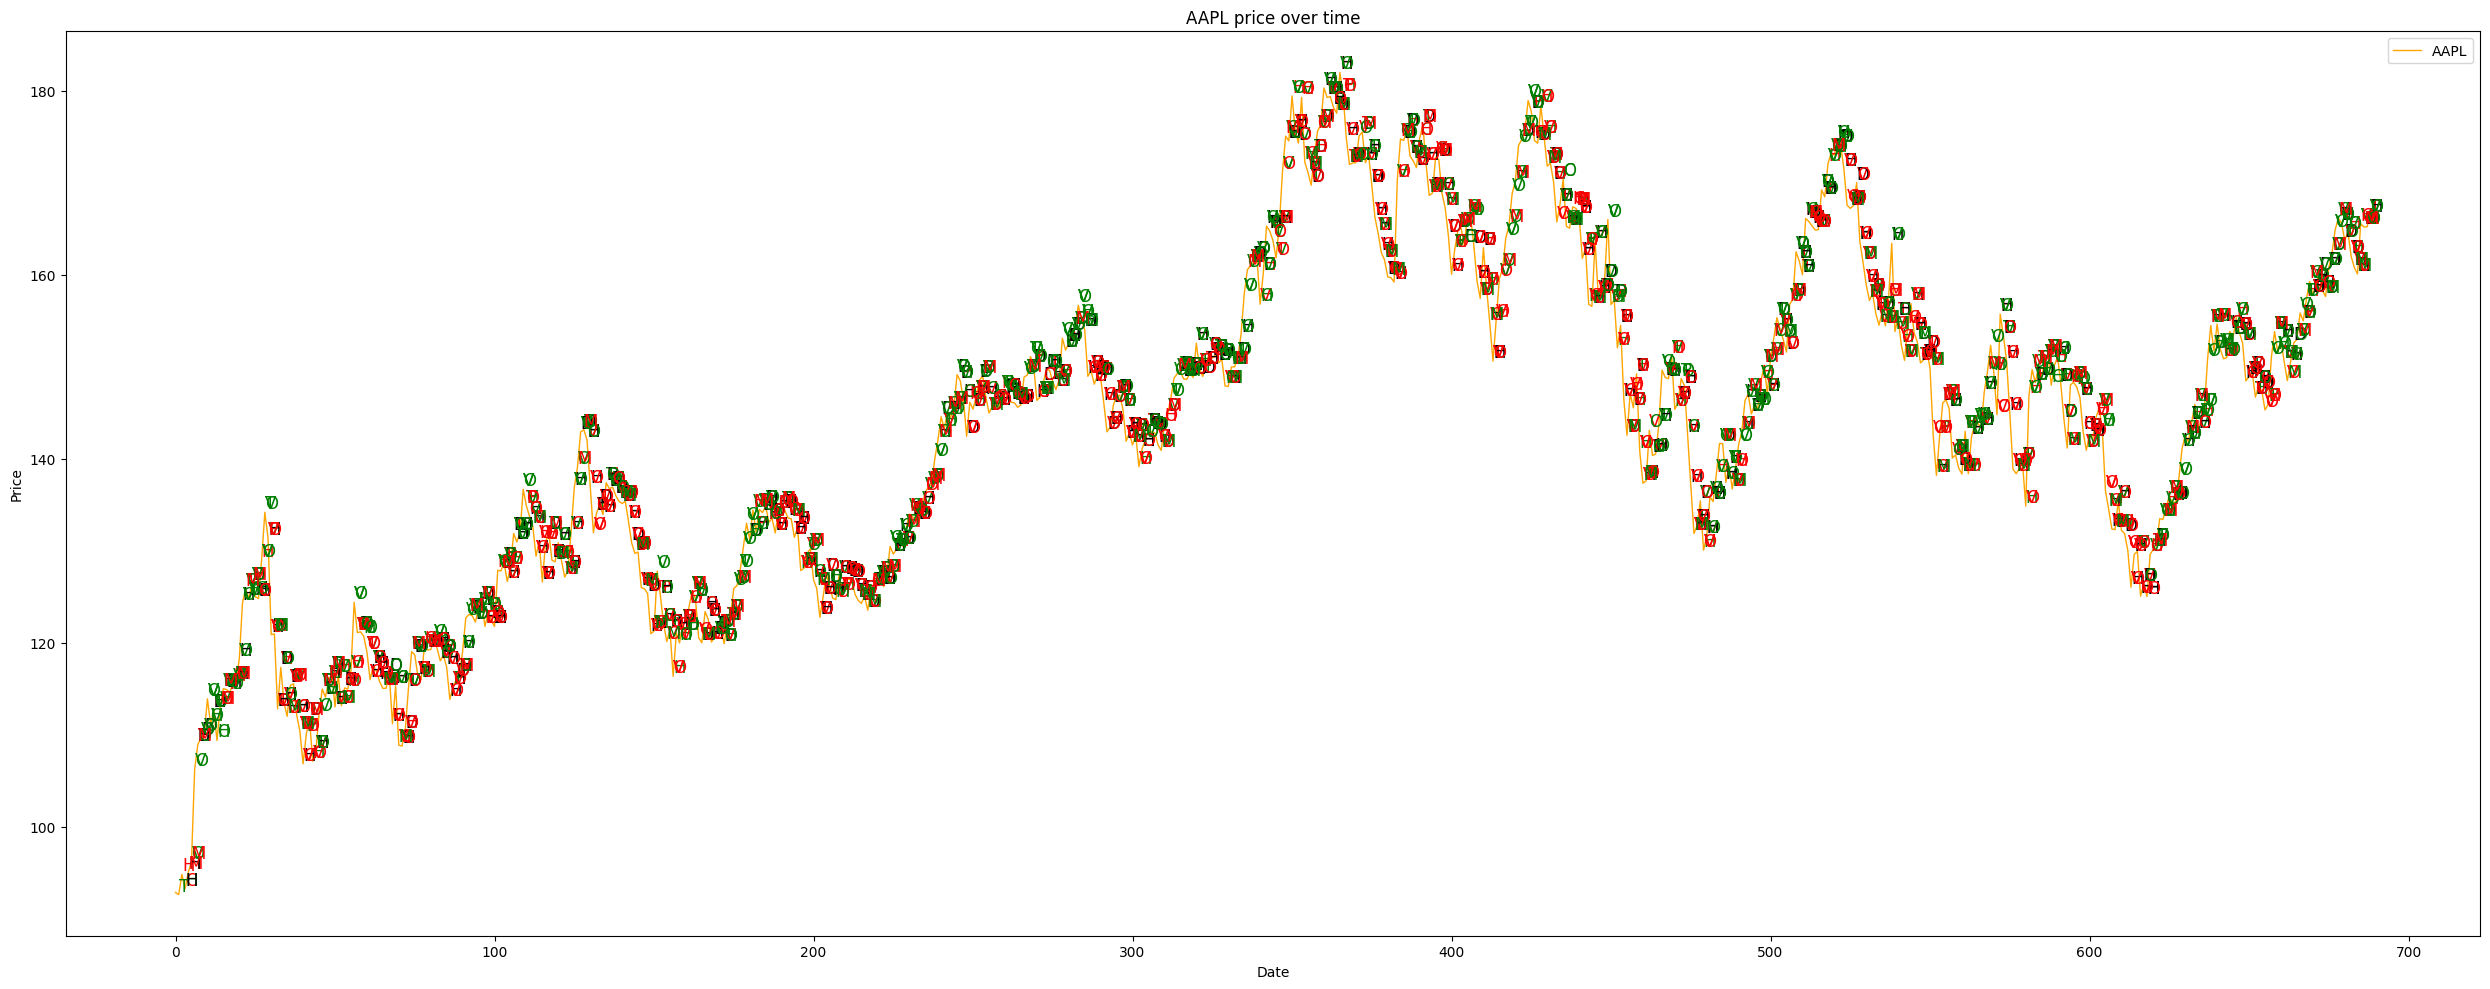

In [47]:
# Create a list of pattern functions to pass to the plot_patterns function
pattern_funcs = [Cobra, Hook, Tail, Harami, Test, Pullback, Vzone, Doji, Hammer, Volume_Climax, OBV, MeanReversion]

# Call the plot_patterns function
plot_patterns(df, pattern_funcs, params)

# 2. Machine Learning and trading strategy

#### Create dataframe with all patterns :

In [48]:
def create_pattern_dataframe(df, pattern_funcs, column, params):
    # Create a new DataFrame to hold the pattern data
    pattern_data = pd.DataFrame(columns=column)
    
    # Iterate through the pattern functions and their corresponding window sizes and time periods
    for pattern_func in pattern_funcs:
        pattern_params = params[pattern_func.__name__]
        window_size = pattern_params.get('window_size')
        time_period = pattern_params.get('time_period')

        pattern_indexes = pattern_func(df, window_size=window_size, time_period=time_period)
        
        # Assign the pattern indexes to the appropriate column in the new DataFrame
        pattern_data[pattern_func.__name__] = pattern_indexes
    return pattern_data

In [119]:
column=["Cobra","Hook", "Tail", "Harami", "Test", "Pullback", "Vzone", "Doji", "Hammer", "Volume_Climax", "OBV","MeanReversion"] 
pattern_funcs = [Cobra, Hook, Tail, Harami, Test, Pullback, Vzone, Doji, Hammer, Volume_Climax, OBV,MeanReversion] 
# Create the dataframe
pattern_data1 = create_pattern_dataframe(df, pattern_funcs,column, params)

In [120]:
pattern_data1

,Cobra,Hook,Tail,Harami,Test,Pullback,Vzone,Doji,Hammer,Volume_Climax,OBV,MeanReversion
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,-1,0,0,0,0,0,0,0,0,0,0
3,-1,1,0,0,0,0,0,0,1,0,0,0
4,0,-1,0,0,0,0,0,0,1,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
684,0,0,0,1,0,0,-1,1,1,-1,-1,1
685,0,-1,0,0,0,0,1,0,0,1,-1,0
686,0,1,0,0,0,-1,0,1,0,0,-1,-1
687,0,-1,1,0,0,0,1,1,0,0,1,0


#### Find the best parameters (window_size, time_period)

In [51]:
def generate_pattern(prices, window_size, time_period, pattern_func):
    return pd.Series(pattern_func(prices, window_size, time_period))

These functions searches for the best combination of window size and time period parameters for a given pattern, such that the resulting pattern has the highest accuracy in predicting the stock market direction using the BestAccuracy function. \
The function returns the best window size, time period, accuracy score, and number of patterns detected

In [52]:
def BestAccuracy(df, pattern):
    correct = 0
    number_patterns = 0
    total = 0
    for i in range(len(pattern) - 1):
        if pd.Series(pattern.iloc[i]).values[0] == 1:
            number_patterns+=1
            if (df.iloc[i]['Close'] > df.iloc[i-1]['Close']) or (df.iloc[i]['Close'] > df.iloc[i-2]['Close']) or (df.iloc[i]['Close'] > df.iloc[i-3]['Close']) :
                correct += 1
            total += 1
        elif pd.Series(pattern.iloc[i]).values[0] == -1:
            number_patterns+=1
            if  (df.iloc[i-1]['Close'] < df.iloc[i]['Close']) or (df.iloc[i-2]['Close'] < df.iloc[i]['Close']) or (df.iloc[i-3]['Close'] < df.iloc[i]['Close']):
                correct += 1
            total += 1
    return correct / total if total != 0 else 0, number_patterns

def find_best_params(df, window_sizes, time_periods, pattern_func, min_patterns=60):
    best_window_size = None
    best_time_period = None
    best_accuracy = 0
    number_patterns = 0
    for window_size in window_sizes:
        for time_period in time_periods:
            pattern = generate_pattern(df, window_size, time_period,pattern_func)
            accuracy, num_patterns = BestAccuracy(df, pattern)
            if accuracy > best_accuracy and (min_patterns is None or num_patterns >= min_patterns):
                best_window_size = window_size
                best_time_period = time_period
                best_accuracy = accuracy
                number_patterns = num_patterns
    return best_window_size, best_time_period, best_accuracy, number_patterns

In [53]:
window_sizes = [i for i in range(1,30)]
time_periods = [i for i in range(1,30)]
#best_window_size, best_time_period, best_accuracy, number_patterns = find_best_params(df, window_sizes, time_periods, OBV)
#print(f"Best window size: {best_window_size}")
#print(f"Best time period: {best_time_period}")
#print(f"Best accuracy: {best_accuracy:.2%}")
#print(f"Number of patterns: {number_patterns}")

Cobra :
Best window size: 1 \
Best time period: 5 \
Best accuracy: 82.54% \
Number of patterns: 63

Tail: 
Best window size: 1 \
Best time period: 1 \
Best accuracy: 61.11% \
Number of patterns: 126

PullBack:
Best window size: 1 \
Best time period: 5 \
Best accuracy: 90.32% \
Number of patterns: 62

VZone:
Best window size: 5 \
Best time period: 5 \
Best accuracy: 72.26% \
Number of patterns: 393

Mean Reversion :
Best window size: 5 \
Best time period: 1 \
Best accuracy: 75.64% \
Number of patterns: 78

OBV : 
Best window size: 3 \
Best time period: 2 \
Best accuracy: 70.73% \
Number of patterns: 492


#### Calculate the accuracy of each pattern

##### Binary Pattern accuracy
This function computes the accuracy of a binary pattern in predicting the direction of the stock market, given stock prices and a number of days n to measure accuracy over. \
It checks if the pattern correctly predicts a specific price movement in the stock market, whether the price goes up if bullish or down if bearish, over a window of n days after the pattern appears. \
The function returns the accuracy (the ratio of correct predictions to the total number of patterns detected) along with the total number of patterns detected.

In [54]:
def PatternAccuracy(df, pattern, n):
    correct = 0
    number_patterns = 0
    total = 0
    for i in range(len(pattern) ): 
        if pd.Series(pattern.iloc[i]).values[0] == 1:
            number_patterns+=1
            if i+n < len(df):
                if (df.iloc[i]['Close'] < df.iloc[i+n]['Close']):

                    correct += 1
                total += 1
        elif pd.Series(pattern.iloc[i]).values[0] == -1:
            number_patterns+=1
            if i+n < len(df):
                if  (df.iloc[i+n]['Close'] > df.iloc[i]['Close']):
                    correct += 1
                total += 1
    return correct / total if total != 0 else 0, number_patterns

##### Reversal Pattern accuracy
This function computes the accuracy of a reversal pattern in predicting the direction of the stock market, given stock prices and a number of days n to measure accuracy over. \
It checks if the pattern correctly predicts a specific price movement in the stock market, whether the price goes up and then down, or down and then up, over a window of n days after the pattern appears. \
The function returns the accuracy (the ratio of correct predictions to the total number of patterns detected) along with the total number of patterns detected.

In [55]:
def PatternAccuracy0_1(df, pattern,n):
    correct = 0
    total = 0
    number_patterns = 0
    for i in range(len(pattern) ): 
        if pd.Series(pattern.iloc[i]).values[0] == 1:
            number_patterns+=1
            if i+n < len(df):
                if (df.iloc[i-n]['Close'] < df.iloc[i]['Close']) and (df.iloc[i]['Close'] > df.iloc[i+n]['Close']) and (df.iloc[i-n]['Close'] > df.iloc[i+n]['Close']):
                    correct += 1

                elif (df.iloc[i-n]['Close'] > df.iloc[i]['Close']) and (df.iloc[i]['Close'] < df.iloc[i+n]['Close']) and (df.iloc[i-n]['Close'] < df.iloc[i+n]['Close']):
                    correct += 1
                total += 1
    return correct / total if total != 0 else 0, number_patterns

In [56]:
def calculate_pattern_accuracies(df, pattern_data, pattern_funcs,n):
    accuracy_data = {}
    for pattern_func in pattern_funcs:
        pattern_name = pattern_func.__name__
        pattern = pattern_data[pattern_name]
        if pattern.dtype == np.dtype('int64'):
            accuracy, number_patterns = PatternAccuracy(df, pattern,n)
            
        elif pattern.dtype == np.dtype('O'):
            accuracy, number_patterns = PatternAccuracy0_1(df, pattern,n)
        accuracy_data[pattern_name] = (accuracy,number_patterns)
    return accuracy_data

def print_pattern_accuracies(accuracy_data):
    for pattern_name, (accuracy, number_patterns) in accuracy_data.items():
        print(f"{pattern_name}: {accuracy:.2%} ({number_patterns} Occurences)")

In [57]:
accuracy_data = calculate_pattern_accuracies(df, pattern_data1, pattern_funcs,3)
print_pattern_accuracies(accuracy_data)

Cobra: 44.71% (85 Occurences)
Hook: 51.15% (350 Occurences)
Tail: 48.09% (185 Occurences)
Harami: 54.26% (129 Occurences)
Test: 51.33% (227 Occurences)
Pullback: 49.41% (86 Occurences)
Vzone: 53.61% (556 Occurences)
Doji: 51.04% (338 Occurences)
Hammer: 51.24% (202 Occurences)
Volume_Climax: 57.10% (318 Occurences)
OBV: 53.01% (684 Occurences)
MeanReversion: 57.38% (184 Occurences)


#### Find the horizon of trading

##### On a single stock

This function calculates the accuracies of each pattern after n days and outputs a recapulatory dataframe:

In [58]:
def calculate_pattern_accuracies_over_time(df, pattern_funcs, n_range):
    pattern_data = create_pattern_dataframe(df, pattern_funcs,column, params)
    accuracy_data = {}
    for pattern_func in pattern_funcs:
        pattern_name = pattern_func.__name__
        pattern = pattern_data[pattern_name]
        accuracy_data[pattern_name] = {}
        if pattern.dtype == np.dtype('int64'):
            for n in n_range:
                accuracy, number_patterns = PatternAccuracy(df, pattern, n)
                accuracy_data[pattern_name][f'Accuracy day {n}'] = accuracy
        elif pattern.dtype == np.dtype('O'):
            for n in n_range:
                accuracy, number_patterns = PatternAccuracy0_1(df, pattern, n)
                accuracy_data[pattern_name][f'Accuracy day {n}'] = accuracy
    return pd.DataFrame.from_dict(accuracy_data, orient='index')


This function applies a gradient color scale to the rows of a given DataFrame based on their values, and returns a styled DataFrame with a yelllow-to-red color scheme:

In [59]:
def color_scale(df):
    
    # set color scale to green-red
    cmap = 'YlOrRd'
    
    # calculate the minimum and maximum values of the DataFrame
    vmin = df.min().min()
    vmax = df.max().max()
    
    # apply gradient color scale to the rows of the DataFrame
    styled_df = df.style.background_gradient(cmap=cmap, axis=0, vmin=vmin, vmax=vmax)
    
    # return the styled DataFrame
    return styled_df


In [60]:
pattern_funcs = [Cobra, Hook, Tail, Harami, Test, Pullback, Vzone, Doji, Hammer, Volume_Climax, OBV,MeanReversion] 
n_range = list(range(1, 31))
tab1=calculate_pattern_accuracies_over_time(df, pattern_funcs, n_range)
tab1=color_scale(tab1)

In [61]:
tab1=color_scale(tab1.data)
tab1

,Accuracy day 1,Accuracy day 2,Accuracy day 3,Accuracy day 4,Accuracy day 5,Accuracy day 6,Accuracy day 7,Accuracy day 8,Accuracy day 9,Accuracy day 10,Accuracy day 11,Accuracy day 12,Accuracy day 13,Accuracy day 14,Accuracy day 15,Accuracy day 16,Accuracy day 17,Accuracy day 18,Accuracy day 19,Accuracy day 20,Accuracy day 21,Accuracy day 22,Accuracy day 23,Accuracy day 24,Accuracy day 25,Accuracy day 26,Accuracy day 27,Accuracy day 28,Accuracy day 29,Accuracy day 30
Cobra,0.411765,0.447059,0.447059,0.470588,0.470588,0.458824,0.494118,0.476190,0.488095,0.488095,0.476190,0.511905,0.523810,0.535714,0.500000,0.530120,0.506024,0.493976,0.493976,0.530120,0.542169,0.566265,0.578313,0.602410,0.602410,0.614458,0.602410,0.614458,0.614458,0.614458
Hook,0.520000,0.507163,0.511494,0.533141,0.533141,0.515850,0.531792,0.507246,0.524638,0.526163,0.523256,0.537791,0.546512,0.527697,0.565598,0.555556,0.552632,0.521994,0.547059,0.538235,0.557522,0.562130,0.562130,0.562130,0.573964,0.578635,0.575668,0.580357,0.588060,0.559880
Tail,0.548913,0.497268,0.480874,0.513661,0.551913,0.568306,0.560440,0.543956,0.569061,0.569061,0.591160,0.558011,0.552486,0.558011,0.583333,0.600000,0.600000,0.592179,0.578652,0.561798,0.573034,0.578652,0.578652,0.589888,0.617978,0.578652,0.595506,0.584270,0.587571,0.598870
Harami,0.511628,0.519380,0.542636,0.565891,0.523438,0.511811,0.543307,0.480315,0.488189,0.488189,0.527559,0.535433,0.559055,0.535433,0.551181,0.566929,0.582677,0.587302,0.579365,0.563492,0.611111,0.619048,0.579365,0.595238,0.603175,0.626984,0.603175,0.608000,0.620968,0.588710
Test,0.517699,0.530973,0.513274,0.517699,0.553097,0.542222,0.535714,0.531250,0.542601,0.554054,0.567568,0.558559,0.567568,0.563063,0.570136,0.590909,0.586364,0.581818,0.579909,0.575342,0.596330,0.603687,0.576037,0.587963,0.606481,0.620370,0.606481,0.620370,0.634259,0.638889
Pullback,0.488372,0.453488,0.494118,0.505882,0.458824,0.470588,0.458824,0.458824,0.517647,0.511905,0.523810,0.523810,0.523810,0.500000,0.488095,0.523810,0.500000,0.500000,0.493976,0.481928,0.493976,0.500000,0.487805,0.463415,0.512195,0.548780,0.512195,0.536585,0.536585,0.512195
Vzone,0.517117,0.528881,0.536101,0.537071,0.541667,0.542650,0.560000,0.535519,0.536496,0.557587,0.556777,0.554128,0.556985,0.561694,0.566421,0.575646,0.567468,0.561111,0.571429,0.572491,0.569832,0.561567,0.558879,0.557009,0.558879,0.571161,0.570356,0.571429,0.581921,0.575472
Doji,0.522255,0.511905,0.510448,0.513433,0.529940,0.552553,0.560241,0.527108,0.540785,0.542424,0.560606,0.551515,0.547112,0.567073,0.574924,0.574924,0.570552,0.578462,0.574074,0.561728,0.577160,0.575851,0.563467,0.566563,0.586957,0.574534,0.596273,0.580745,0.585670,0.585670
Hammer,0.527363,0.552239,0.512438,0.542289,0.595000,0.580000,0.600000,0.625000,0.620000,0.650000,0.623116,0.628141,0.628141,0.621212,0.621212,0.639594,0.634518,0.622449,0.625641,0.589744,0.620513,0.600000,0.589744,0.615385,0.615385,0.618557,0.634021,0.632124,0.658031,0.632124
Volume_Climax,0.520505,0.552050,0.570978,0.537975,0.565079,0.561905,0.570064,0.566879,0.562300,0.591054,0.581470,0.583333,0.589744,0.588424,0.588424,0.575563,0.575563,0.569132,0.574194,0.582524,0.585761,0.581169,0.594156,0.586319,0.592834,0.598039,0.586885,0.592105,0.585526,0.601974


##### On multiple stocks :

This function calculates the best horizon for a specified number of stocks, here it loops over 100 stocks of the NASDAQ using the API, and computes the mean accuracies for each pattern over a range of days

In [62]:
def calculate_best_horizon(num_tickers):
    # get a list of tickers
    tickers = get_tickers(num_tickers)
    # set up pattern functions and n range
    pattern_funcs = [Cobra, Hook, Tail, Harami, Test, Pullback, Vzone, Doji, Hammer, OBV, Volume_Climax, MeanReversion] 
    n_range = list(range(1,31)) 
    # loop over the tickers and calculate the accuracy data
    accuracy_data = pd.DataFrame()
    for ticker in tickers:
        df, symbol = get_stock_data(ticker)
        pattern_accuracy = calculate_pattern_accuracies_over_time(df, pattern_funcs, n_range)
        accuracy_data = pd.concat([accuracy_data, pattern_accuracy])
    return accuracy_data.groupby(level=0).mean()

In [63]:
num_tickers=50
tab2=calculate_best_horizon(num_tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [64]:
tab2=color_scale(tab2)
tab2

,Accuracy day 1,Accuracy day 2,Accuracy day 3,Accuracy day 4,Accuracy day 5,Accuracy day 6,Accuracy day 7,Accuracy day 8,Accuracy day 9,Accuracy day 10,Accuracy day 11,Accuracy day 12,Accuracy day 13,Accuracy day 14,Accuracy day 15,Accuracy day 16,Accuracy day 17,Accuracy day 18,Accuracy day 19,Accuracy day 20,Accuracy day 21,Accuracy day 22,Accuracy day 23,Accuracy day 24,Accuracy day 25,Accuracy day 26,Accuracy day 27,Accuracy day 28,Accuracy day 29,Accuracy day 30
Cobra,0.487621,0.500669,0.498134,0.500909,0.494316,0.501113,0.501782,0.508085,0.502450,0.503096,0.495296,0.498441,0.502621,0.493783,0.492473,0.485895,0.482666,0.481763,0.480548,0.479257,0.481377,0.482350,0.475933,0.476170,0.471933,0.471419,0.470047,0.472236,0.474759,0.469391
Doji,0.496723,0.503382,0.502846,0.507115,0.506816,0.506924,0.509228,0.506056,0.503535,0.497442,0.499008,0.498101,0.496933,0.499181,0.498177,0.499056,0.497282,0.496779,0.495079,0.493248,0.497490,0.493983,0.495123,0.493778,0.496969,0.493336,0.493862,0.491963,0.494014,0.490500
Hammer,0.515400,0.530724,0.526746,0.528031,0.525364,0.521374,0.519109,0.524447,0.520923,0.518827,0.519944,0.517909,0.511208,0.509838,0.509613,0.506526,0.505680,0.501772,0.497992,0.492260,0.498344,0.498064,0.495927,0.496750,0.498859,0.500306,0.501124,0.502802,0.501546,0.499100
Harami,0.500571,0.512381,0.514757,0.524052,0.515392,0.510347,0.510510,0.511042,0.507726,0.505646,0.513349,0.514254,0.510253,0.510581,0.514321,0.510136,0.508599,0.511980,0.512836,0.505184,0.512804,0.511107,0.514497,0.514557,0.514687,0.511657,0.509765,0.510769,0.511938,0.515118
Hook,0.491684,0.508023,0.510068,0.511268,0.508443,0.507811,0.508504,0.511385,0.509524,0.508181,0.507736,0.506762,0.505974,0.503160,0.503219,0.497264,0.496567,0.494600,0.493522,0.495692,0.497313,0.495611,0.494545,0.491835,0.493269,0.492767,0.490429,0.489426,0.490086,0.488488
MeanReversion,0.487980,0.496247,0.495767,0.497455,0.507443,0.503977,0.504816,0.508789,0.503277,0.501349,0.505401,0.503395,0.500115,0.498337,0.497995,0.502783,0.499617,0.499451,0.496139,0.493727,0.496378,0.493722,0.494038,0.488257,0.490642,0.490767,0.490821,0.486786,0.484917,0.483980
OBV,0.491331,0.502253,0.502106,0.505554,0.504845,0.505926,0.504980,0.507675,0.504905,0.501681,0.501926,0.501738,0.500593,0.499898,0.500813,0.498284,0.498185,0.496099,0.494437,0.493175,0.494209,0.493656,0.493896,0.491311,0.492914,0.491710,0.491167,0.490638,0.491158,0.489404
Pullback,0.487400,0.502685,0.505155,0.507201,0.490982,0.490758,0.509844,0.491895,0.500957,0.497003,0.498667,0.494167,0.500144,0.497166,0.496449,0.496723,0.490931,0.490232,0.487259,0.495711,0.494103,0.483474,0.492402,0.481990,0.488529,0.487768,0.485846,0.491288,0.490416,0.491531
Tail,0.494678,0.503724,0.506130,0.514117,0.515016,0.516322,0.516629,0.513611,0.510261,0.506005,0.505957,0.505751,0.503194,0.502253,0.500921,0.500946,0.497787,0.497904,0.495870,0.494530,0.497691,0.500015,0.503031,0.497932,0.500430,0.498588,0.496921,0.498214,0.494316,0.490812
Test,0.497994,0.510200,0.506057,0.513709,0.512666,0.506541,0.508453,0.509534,0.507269,0.502093,0.503943,0.502879,0.502654,0.504772,0.502989,0.499845,0.498892,0.498417,0.492588,0.495976,0.493234,0.492296,0.498245,0.493146,0.494961,0.496631,0.495072,0.492283,0.494930,0.491421


In [65]:
def recap_best_horizon(data):
    # calculate the mean accuracy across all stocks for each of the best days
    accuracy_means = data.mean()
    best_horizon = accuracy_means.nlargest(5)
    
    return best_horizon

In [66]:
recap_best_horizon(tab2.data)

Accuracy day 4    0.509905
Accuracy day 8    0.509521
Accuracy day 7    0.509175
Accuracy day 5    0.507886
Accuracy day 6    0.507579
dtype: float64

This function finds the best trading days based on the highest accuracies observed for each pattern:

In [67]:
def find_best_trading_days(num_tickers, n_range):
    # get a list of tickers
    tickers = get_tickers(num_tickers)
    # set up pattern functions
    pattern_funcs = [Cobra, Hook, Tail, Harami, Test, Pullback, Vzone, Doji, Hammer, OBV, Volume_Climax, MeanReversion] 
    # initialize dictionaries to store best days and occurrences
    best_days = {}
    occurrences = {}
    # loop over the tickers
    for ticker in tickers:
        # get stock data
        df, symbol = get_stock_data(ticker)
        # create pattern dataframe
        pattern_data = create_pattern_dataframe(df, pattern_funcs, column, params)
        # calculate pattern accuracies over time
        pattern_accuracy = calculate_pattern_accuracies_over_time(df, pattern_funcs, n_range)
        # loop over patterns and find best day for each
        for pattern_name, pattern_data in pattern_accuracy.iterrows():
            max_accuracy = pattern_data.max()
            max_accuracy_day = pattern_data.idxmax()
            # update best days dictionary
            if pattern_name not in best_days or best_days[pattern_name][0] < max_accuracy:
                best_days[pattern_name] = (max_accuracy, max_accuracy_day)
            elif best_days[pattern_name][0] == max_accuracy:
                if max_accuracy_day in best_days[pattern_name]:
                    best_days[pattern_name][max_accuracy_day] += 1
                else:
                    best_days[pattern_name] = (max_accuracy, max_accuracy_day)
            # update occurrences dictionary
            if max_accuracy_day in occurrences:
                occurrences[max_accuracy_day] += 1
            else:
                occurrences[max_accuracy_day] = 1
    # find the day with the most occurrences for each pattern
    best_horizon = {}
    for pattern_name, data in best_days.items():
        best_horizon[pattern_name] = max(data[1:], key=lambda x: occurrences[x])
    return best_horizon


In [68]:
n_range = list(range(1, 31))
num_tickers = 10
find_best_trading_days(num_tickers, n_range)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


{'Cobra': 'Accuracy day 18',
 'Hook': 'Accuracy day 27',
 'Tail': 'Accuracy day 27',
 'Harami': 'Accuracy day 24',
 'Test': 'Accuracy day 30',
 'Pullback': 'Accuracy day 20',
 'Vzone': 'Accuracy day 30',
 'Doji': 'Accuracy day 30',
 'Hammer': 'Accuracy day 27',
 'OBV': 'Accuracy day 30',
 'Volume_Climax': 'Accuracy day 28',
 'MeanReversion': 'Accuracy day 27'}

{'Cobra': 'Accuracy day 27', \
 'Hook': 'Accuracy day 27', \
 'Tail': 'Accuracy day 27', \
 'Harami': 'Accuracy day 24', \
 'Test': 'Accuracy day 30', \
 'Pullback': 'Accuracy day 30', \
 'Vzone': 'Accuracy day 30' \
 'Doji': 'Accuracy day 25', \
 'Hammer': 'Accuracy day 27', \
 'OBV': 'Accuracy day 30', \
 'Volume_Climax': 'Accuracy day 27', \
 'MeanReversion': 'Accuracy day 20'}

##### Finding Stop Loss and Take Profit

In [71]:
def PatternAccuracy(df, pattern, n, stop_loss, take_profit):
    correct = 0
    number_patterns = 0
    total = 0
    for i in range(len(pattern)):
        if pd.Series(pattern.iloc[i]).values[0] == 1:
            number_patterns += 1
            if i + n < len(df):
                if (df.iloc[i]['Close'] - df.iloc[i + n]['Close']) / df.iloc[i]['Close'] >= stop_loss:
                    correct += 1
                total += 1
        elif pd.Series(pattern.iloc[i]).values[0] == -1:
            number_patterns += 1
            if i + n < len(df):
                if (df.iloc[i + n]['Close'] - df.iloc[i]['Close']) / df.iloc[i]['Close'] >= take_profit:
                    correct += 1
                total += 1
    return correct / total if total != 0 else 0, number_patterns


def PatternAccuracy0_1(df, pattern, n, stop_loss, take_profit):
    correct = 0
    total = 0
    number_patterns = 0
    for i in range(len(pattern)):
        if pd.Series(pattern.iloc[i]).values[0] == 1:
            number_patterns += 1
            if i + n < len(df):
                if (df.iloc[i]['Close'] - df.iloc[i + n]['Close']) / df.iloc[i]['Close'] >= stop_loss:
                    correct += 1
                total += 1
        elif pd.Series(pattern.iloc[i]).values[0] == -1:
            number_patterns += 1
            if i + n < len(df):
                if (df.iloc[i + n]['Close'] - df.iloc[i]['Close']) / df.iloc[i]['Close'] >= take_profit:
                    correct += 1
                total += 1
    return correct / total if total != 0 else 0, number_patterns


def find_best_trading_days(num_tickers, n_range, horizon):
    tickers = get_tickers(num_tickers)
    pattern_funcs = [Cobra, Hook, Tail, Harami, Test, Pullback, Vzone, Doji, Hammer, OBV, Volume_Climax, MeanReversion]

    stop_loss_range = np.arange(0.01, 0.11, 0.01)
    take_profit_range = np.arange(0.01, 0.31, 0.01)

    best_params = {}
    for ticker in tickers:
        df, symbol = get_stock_data(ticker)
        pattern_data = create_pattern_dataframe(df, pattern_funcs, column, params)

        for pattern_func in pattern_funcs:
            pattern_name = pattern_func.__name__
            pattern = pattern_data[pattern_name]
            best_accuracy = 0
            best_stop_loss = 0
            best_take_profit = 0

            for stop_loss in stop_loss_range:
                for take_profit in take_profit_range:
                    if pattern.dtype == np.dtype('int64'):
                        accuracy, _ = PatternAccuracy(df, pattern, horizon, stop_loss, take_profit)
                    elif pattern.dtype == np.dtype('O'):
                        accuracy, _ = PatternAccuracy0_1(df, pattern, horizon, stop_loss, take_profit)

                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_stop_loss = stop_loss
                        best_take_profit = take_profit

            # Store the best stop loss and take profit percentages for each pattern
            if pattern_name not in best_params:
                best_params[pattern_name] = {'Best Accuracy': best_accuracy,
                                              'Best Stop Loss %': best_stop_loss * 100,
                                              'Best Take Profit %': best_take_profit * 100}
            else:
                if best_params[pattern_name]['Best Accuracy'] < best_accuracy:
                    best_params[pattern_name]['Best Accuracy'] = best_accuracy
                    best_params[pattern_name]['Best Stop Loss %'] = best_stop_loss * 100
                    best_params[pattern_name]['Best Take Profit %'] = best_take_profit * 100

    return pd.DataFrame.from_dict(best_params, orient='index')


In [ ]:
num_tickers = 10  # number of tickers to analyze
n_range = list(range(1, 31))  # the range of days to test the patterns

# Call the function with the provided parameters
#best_trading_days_df = find_best_trading_days(num_tickers, n_range, 27)

# Display the resulting DataFrame
print(best_trading_days_df)

### Machine Learning 

In [74]:
def calculate_pattern_accuracy(df, pattern, n):
    total = 0
    correct = 0
    for i in range(len(df) - n):
        if pattern.iloc[i] != 0:
            total += 1
            if (pattern.iloc[i] > 0) == (df['Close'].iloc[i + n] > df['Close'].iloc[i]):
                correct += 1
    if total == 0:
        return None, 0
    else:
        return correct / total, total

def calculate_pattern_accuracies(df, pattern_data, pattern_funcs, n):
    accuracy_data = {}
    for pattern_func in pattern_funcs:
        pattern_name = pattern_func.__name__
        pattern = pattern_data[pattern_name]
        accuracy, number_patterns = calculate_pattern_accuracy(df, pattern, n)
        accuracy_data[pattern_name] = (accuracy, number_patterns)
    return accuracy_data

def calculate_pattern_accuracies_on_day_n(num_tickers, pattern_funcs, n):
    tickers = get_tickers(num_tickers)
    accuracies = []
    
    for ticker in tickers:
        df, symbol = get_stock_data(ticker)
        pattern_data = create_pattern_dataframe(df, pattern_funcs, column, params)
        accuracy_data = calculate_pattern_accuracies(df, pattern_data, pattern_funcs, n)
        accuracies.append(accuracy_data)
    
    combined_data = {}
    for ticker_accuracies in accuracies:
        for pattern_name, (accuracy, count) in ticker_accuracies.items():
            if pattern_name not in combined_data:
                combined_data[pattern_name] = {"total_accuracies": 0, "total_count": 0}
            if accuracy is not None:
                combined_data[pattern_name]["total_accuracies"] += accuracy * count
                combined_data[pattern_name]["total_count"] += count
    
    final_accuracies = {}
    for pattern_name, data in combined_data.items():
        if data["total_count"] > 0:
            final_accuracies[pattern_name] = data["total_accuracies"] / data["total_count"]
        else:
            final_accuracies[pattern_name] = None
    
    return final_accuracies

In [77]:
num_tickers = 100
pattern_funcs = [Cobra, Hook, Tail, Harami, Test, Pullback, Vzone, Doji, Hammer, OBV, Volume_Climax, MeanReversion]
n = 27
accuracies = calculate_pattern_accuracies_on_day_n(num_tickers, pattern_funcs, n)
print(accuracies)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [109]:
def calculate_pattern_importance(accuracy_data, num_tickers):
    # Compute importance of each pattern
    pattern_importance = {}
    for pattern_name, accuracy_score in accuracy_data.items():
        pattern_importance[pattern_name] = accuracy_score

    # Normalize importance scores
    pattern_importance_norm = {pattern_name: score/num_tickers for pattern_name, score in pattern_importance.items()}

    # Use importance scores as weights for each pattern
    pattern_weights = {}
    total_pattern_importance = sum(pattern_importance_norm.values())
    for pattern_name, score in pattern_importance_norm.items():
        pattern_weights[pattern_name] = score/total_pattern_importance

    return pattern_weights

In [110]:
def calculate_percentage_change_in_weights(pattern_weights):
    # Compute the percentage change in pattern weights
    percentage_change_weights = {}
    prev_weight = 0
    
    for pattern_name, weight in pattern_weights.items():
        if prev_weight == 0:
            percentage_change = 0
        else:
            percentage_change = ((weight - prev_weight) / prev_weight) * 100
        
        percentage_change_weights[pattern_name] = percentage_change
        prev_weight = weight
    
    return percentage_change_weights


In [111]:
# Compute the pattern weights using the calculate_pattern_importance function
pattern_weights = calculate_pattern_importance(accuracies, 100)

# Compute the percentage change in pattern weights
percentage_change_weights = calculate_percentage_change_in_weights(pattern_weights)
percentage_change_weights

{'Cobra': 0,
 'Hook': -0.00035336465637821973,
 'Tail': -2.321893426250443,
 'Harami': 2.7615861021827386,
 'Test': -2.4346107822384355,
 'Pullback': 0.25977530487279704,
 'Vzone': 0.54442956477713,
 'Doji': 0.4920678747764239,
 'Hammer': 2.713237596334957,
 'OBV': -3.129749627784822,
 'Volume_Climax': -0.1006294235202311,
 'MeanReversion': 3.633532874750192}

In [112]:
def create_pattern_dataframe_ml(df, pattern_funcs, column, params):
    # Create a new DataFrame to hold the pattern data
    pattern_data = pd.DataFrame(columns=column)
    
    # Iterate through the pattern functions and their corresponding window sizes and time periods
    for pattern_func in pattern_funcs:
        pattern_params = params[pattern_func.__name__]
        window_size = pattern_params.get('window_size')
        time_period = pattern_params.get('time_period')

        pattern_indexes = pattern_func(df, window_size=window_size, time_period=time_period)
        if pattern_func.__name__=='Cobra':
            pattern_series = pd.Series(pattern_indexes)
        else:
            pattern_series = pd.Series(pattern_indexes).multiply(percentage_change_weights[pattern_func.__name__])
        # Assign the pattern indexes to the appropriate column in the new DataFrame
        pattern_data[pattern_func.__name__] = pattern_series

    return pattern_data

In [113]:
column=["Cobra","Hook", "Tail", "Harami", "Test", "Pullback", "Vzone", "Doji", "Hammer", "Volume_Climax", "OBV","MeanReversion"] 
pattern_funcs = [Cobra, Hook, Tail, Harami, Test, Pullback, Vzone, Doji, Hammer, Volume_Climax, OBV,MeanReversion] 
# Create the dataframe
features_df = create_pattern_dataframe_ml(df, pattern_funcs,column, params)

In [114]:
features_df

,Cobra,Hook,Tail,Harami,Test,Pullback,Vzone,Doji,Hammer,Volume_Climax,OBV,MeanReversion
0,0,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.00000,0.000000,0.000000,-0.000000,-0.00000,0.000000
1,0,-0.000000,-0.000000,0.000000,-2.434611,0.000000,0.00000,0.000000,0.000000,-0.000000,-0.00000,0.000000
2,0,0.000353,-0.000000,0.000000,-0.000000,0.000000,0.00000,0.000000,0.000000,-0.000000,-0.00000,0.000000
3,-1,-0.000353,-0.000000,0.000000,-0.000000,0.000000,0.00000,0.000000,2.713238,-0.000000,-0.00000,0.000000
4,0,0.000353,-0.000000,0.000000,-0.000000,0.000000,0.00000,0.000000,2.713238,-0.000000,-0.00000,-3.633533
...,...,...,...,...,...,...,...,...,...,...,...,...
684,0,-0.000000,-0.000000,2.761586,-0.000000,0.000000,-0.54443,0.492068,2.713238,0.100629,3.12975,3.633533
685,0,0.000353,-0.000000,0.000000,-0.000000,0.000000,0.54443,0.000000,0.000000,-0.100629,3.12975,0.000000
686,0,-0.000353,-0.000000,0.000000,-0.000000,-0.259775,0.00000,0.492068,0.000000,-0.000000,3.12975,-3.633533
687,0,0.000353,-2.321893,0.000000,-0.000000,0.000000,0.54443,0.492068,0.000000,-0.000000,-3.12975,0.000000


In [121]:
features_df = pd.DataFrame(pattern_data1)

# Create interaction features
pattern_names = list(features_df.columns)
for i in range(len(pattern_names)):
    for j in range(i + 1, len(pattern_names)):
        pattern1 = pattern_names[i]
        pattern2 = pattern_names[j]
        interaction_feature_name = f'{pattern1}_x_{pattern2}'
        features_df[interaction_feature_name] = features_df[pattern1] * features_df[pattern2]

print(features_df)


     Cobra  Hook  Tail  Harami  Test  Pullback  Vzone  Doji  Hammer   
0        0     0     0       0     0         0      0     0       0  \
1        0     0     0       0     1         0      0     0       0   
2        0    -1     0       0     0         0      0     0       0   
3       -1     1     0       0     0         0      0     0       1   
4        0    -1     0       0     0         0      0     0       1   
..     ...   ...   ...     ...   ...       ...    ...   ...     ...   
684      0     0     0       1     0         0     -1     1       1   
685      0    -1     0       0     0         0      1     0       0   
686      0     1     0       0     0        -1      0     1       0   
687      0    -1     1       0     0         0      1     1       0   
688      0     0    -1       0    -1         0      1     1       1   

     Volume_Climax  ...  Doji_x_Hammer  Doji_x_Volume_Climax  Doji_x_OBV   
0                0  ...              0                     0           

In [122]:
combined_df = pd.concat([features_df, interaction_features_df], axis=1)

In [124]:
ticker = get_tickers(1)
price_data=get_stock_data(ticker)[0]
# Assuming you have a DataFrame named price_data with a column named price_column
combined_df['future_return'] = price_data['Close'].shift(-5) / price_data['Close'] - 1


[*********************100%***********************]  1 of 1 completed


/var/folders/2s/jns356yn7yd2n2r8r6gql3h00000gq/T/ipykernel_30534/334308475.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['future_return'] = price_data['Close'].shift(-5) / price_data['Close'] - 1


In [125]:
combined_df

,Cobra,Hook,Tail,Harami,Test,Pullback,Vzone,Doji,Hammer,Volume_Climax,...,OBV_x_Cobra_x_Harami_x_Doji_x_MeanReversion,OBV_x_Cobra_x_Harami_x_Hammer_x_Volume_Climax,OBV_x_Cobra_x_Harami_x_Hammer_x_OBV,OBV_x_Cobra_x_Harami_x_Hammer_x_MeanReversion,OBV_x_Cobra_x_Harami_x_Volume_Climax_x_OBV,OBV_x_Cobra_x_Harami_x_Volume_Climax_x_MeanReversion,OBV_x_Cobra_x_Harami_x_OBV_x_MeanReversion,OBV_x_Cobra_x_Test_x_Cobra_x_Pullback,OBV_x_Cobra_x_Test_x_Cobra_x_Vzone,future_return
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.031621
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.023529
2,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.026295
3,-1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.023622
4,0,-1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.009747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,0,0,0,1,0,0,-1,1,1,-1,...,0,0,0,0,0,0,0,0,0,NaN
685,0,-1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
686,0,1,0,0,0,-1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,NaN
687,0,-1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [126]:
combined_df=combined_df.dropna()

In [127]:
combined_df

,Cobra,Hook,Tail,Harami,Test,Pullback,Vzone,Doji,Hammer,Volume_Climax,...,OBV_x_Cobra_x_Harami_x_Doji_x_MeanReversion,OBV_x_Cobra_x_Harami_x_Hammer_x_Volume_Climax,OBV_x_Cobra_x_Harami_x_Hammer_x_OBV,OBV_x_Cobra_x_Harami_x_Hammer_x_MeanReversion,OBV_x_Cobra_x_Harami_x_Volume_Climax_x_OBV,OBV_x_Cobra_x_Harami_x_Volume_Climax_x_MeanReversion,OBV_x_Cobra_x_Harami_x_OBV_x_MeanReversion,OBV_x_Cobra_x_Test_x_Cobra_x_Pullback,OBV_x_Cobra_x_Test_x_Cobra_x_Vzone,future_return
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.031621
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.023529
2,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.026295
3,-1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.023622
4,0,-1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.009747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,0,0,0,1,0,0,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.025371
413,0,0,-1,0,0,0,-1,1,1,-1,...,0,0,0,0,0,0,0,0,0,-0.011707
414,0,-1,0,0,0,0,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.016854
415,0,0,0,0,0,0,-1,0,0,1,...,0,0,0,0,0,0,0,0,0,0.004359


Feature Scaling

In [128]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [129]:
# Separate features and target variable
X = combined_df.drop('future_return', axis=1)
y = combined_df['future_return']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

Models :

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [160]:
# Prepare the dataset
X = X_scaled_df
y = combined_df['future_return'].apply(lambda x: 1 if x > 0 else 0)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model selection and training
model = LogisticRegression(penalty='l1', C=0.051, solver='liblinear')
model.fit(X_train, y_train)

# Model evaluation
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Training set classification report:")
print(classification_report(y_train, y_pred_train))
print("Training set accuracy:", accuracy_score(y_train, y_pred_train))

print("Testing set classification report:")
print(classification_report(y_test, y_pred_test))
print("Testing set accuracy:", accuracy_score(y_test, y_pred_test))


Training set classification report:
              precision    recall  f1-score   support

           0       0.65      0.87      0.74       189
           1       0.69      0.38      0.49       144

    accuracy                           0.66       333
   macro avg       0.67      0.62      0.62       333
weighted avg       0.67      0.66      0.63       333

Training set accuracy: 0.6576576576576577
Testing set classification report:
              precision    recall  f1-score   support

           0       0.58      0.85      0.69        47
           1       0.53      0.22      0.31        37

    accuracy                           0.57        84
   macro avg       0.56      0.53      0.50        84
weighted avg       0.56      0.57      0.52        84

Testing set accuracy: 0.5714285714285714


In [132]:
from sklearn.svm import SVC

In [173]:
# Assuming your dataset is stored in a DataFrame named pattern_data2
# and your target variable is in the 'future_return' column
X = X_scaled_df
y = combined_df['future_return'].apply(lambda x: 1 if x > 0 else 0)

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize the SVM model with a radial basis function (RBF) kernel
svm_model = SVC(C=0.7,kernel='rbf')

# Train the model using the training data
svm_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = svm_model.predict(X_train)

# Make predictions on the testing set
y_test_pred = svm_model.predict(X_test)

# Print the classification reports and accuracy scores
print("Training set classification report:")
print(classification_report(y_train, y_train_pred))

print("Training set accuracy:", accuracy_score(y_train, y_train_pred))

print("\nTesting set classification report:")
print(classification_report(y_test, y_test_pred))

print("Testing set accuracy:", accuracy_score(y_test, y_test_pred))

Training set classification report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       172
           1       1.00      0.15      0.26       119

    accuracy                           0.65       291
   macro avg       0.82      0.58      0.52       291
weighted avg       0.78      0.65      0.56       291

Training set accuracy: 0.6529209621993127

Testing set classification report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68        64
           1       1.00      0.02      0.03        62

    accuracy                           0.52       126
   macro avg       0.76      0.51      0.35       126
weighted avg       0.75      0.52      0.36       126

Testing set accuracy: 0.5158730158730159


Decision Tree

In [134]:
from sklearn.tree import DecisionTreeClassifier

In [135]:
# Assuming your dataset is stored in a DataFrame named pattern_data2
# and your target variable is in the 'future_return' column
X = X_scaled_df
y = combined_df['future_return'].apply(lambda x: 1 if x > 0 else 0)

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier()

# Train the model using the training data
dt_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = dt_model.predict(X_train)

# Make predictions on the testing set
y_test_pred = dt_model.predict(X_test)

# Print the classification reports and accuracy scores
print("Training set classification report:")
print(classification_report(y_train, y_train_pred))

print("Training set accuracy:", accuracy_score(y_train, y_train_pred))

print("\nTesting set classification report:")
print(classification_report(y_test, y_test_pred))

print("Testing set accuracy:", accuracy_score(y_test, y_test_pred))


Training set classification report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       172
           1       0.99      0.79      0.88       119

    accuracy                           0.91       291
   macro avg       0.93      0.89      0.90       291
weighted avg       0.92      0.91      0.91       291

Training set accuracy: 0.9106529209621993

Testing set classification report:
              precision    recall  f1-score   support

           0       0.49      0.58      0.53        64
           1       0.47      0.39      0.42        62

    accuracy                           0.48       126
   macro avg       0.48      0.48      0.48       126
weighted avg       0.48      0.48      0.48       126

Testing set accuracy: 0.48412698412698413


Random Forest

In [176]:
from sklearn.ensemble import RandomForestClassifier

In [177]:
# Prepare the dataset
X = X_scaled_df
y = combined_df['future_return'].apply(lambda x: 1 if x > 0 else 0)

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using the training data
rf_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf_model.predict(X_train)

# Make predictions on the testing set
y_test_pred = rf_model.predict(X_test)

# Print the classification reports and accuracy scores
print("Training set classification report:")
print(classification_report(y_train, y_train_pred))

print("Training set accuracy:", accuracy_score(y_train, y_train_pred))

print("\nTesting set classification report:")
print(classification_report(y_test, y_test_pred))

print("Testing set accuracy:", accuracy_score(y_test, y_test_pred))


Training set classification report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       172
           1       0.93      0.84      0.88       119

    accuracy                           0.91       291
   macro avg       0.92      0.90      0.91       291
weighted avg       0.91      0.91      0.91       291

Training set accuracy: 0.9106529209621993

Testing set classification report:
              precision    recall  f1-score   support

           0       0.52      0.67      0.59        64
           1       0.52      0.37      0.43        62

    accuracy                           0.52       126
   macro avg       0.52      0.52      0.51       126
weighted avg       0.52      0.52      0.51       126

Testing set accuracy: 0.5238095238095238


Gradient Boosting

In [178]:
from sklearn.ensemble import GradientBoostingClassifier

In [179]:
# Prepare the dataset
X = X_scaled_df
y = combined_df['future_return'].apply(lambda x: 1 if x > 0 else 0)

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model using the training data
gb_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = gb_model.predict(X_train)

# Make predictions on the testing set
y_test_pred = gb_model.predict(X_test)

# Print the classification reports and accuracy scores
print("Training set classification report:")
print(classification_report(y_train, y_train_pred))

print("Training set accuracy:", accuracy_score(y_train, y_train_pred))

print("\nTesting set classification report:")
print(classification_report(y_test, y_test_pred))

print("Testing set accuracy:", accuracy_score(y_test, y_test_pred))


Training set classification report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       172
           1       0.92      0.71      0.80       119

    accuracy                           0.86       291
   macro avg       0.87      0.83      0.84       291
weighted avg       0.87      0.86      0.85       291

Training set accuracy: 0.8556701030927835

Testing set classification report:
              precision    recall  f1-score   support

           0       0.51      0.69      0.59        64
           1       0.50      0.32      0.39        62

    accuracy                           0.51       126
   macro avg       0.51      0.51      0.49       126
weighted avg       0.51      0.51      0.49       126

Testing set accuracy: 0.5079365079365079


Bagging

In [181]:
from sklearn.ensemble import BaggingClassifier

In [182]:
# Prepare the dataset
X = X_scaled_df
y = combined_df['future_return'].apply(lambda x: 1 if x > 0 else 0)

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize the base estimator, a Decision Tree in this case
base_estimator = DecisionTreeClassifier(random_state=42)

# Initialize the Bagging model
bagging_model = BaggingClassifier(base_estimator=base_estimator, n_estimators=100, random_state=42)

# Train the model using the training data
bagging_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = bagging_model.predict(X_train)

# Make predictions on the testing set
y_test_pred = bagging_model.predict(X_test)

# Print the classification reports and accuracy scores
print("Training set classification report:")
print(classification_report(y_train, y_train_pred))

print("Training set accuracy:", accuracy_score(y_train, y_train_pred))

print("\nTesting set classification report:")
print(classification_report(y_test, y_test_pred))

print("Testing set accuracy:", accuracy_score(y_test, y_test_pred))


/opt/homebrew/Cellar/jupyterlab/3.6.1/libexec/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training set classification report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       172
           1       0.96      0.82      0.88       119

    accuracy                           0.91       291
   macro avg       0.92      0.90      0.90       291
weighted avg       0.92      0.91      0.91       291

Training set accuracy: 0.9106529209621993

Testing set classification report:
              precision    recall  f1-score   support

           0       0.52      0.70      0.60        64
           1       0.53      0.34      0.41        62

    accuracy                           0.52       126
   macro avg       0.52      0.52      0.51       126
weighted avg       0.52      0.52      0.51       126

Testing set accuracy: 0.5238095238095238


Fitted decision tree 

In [174]:
from sklearn.model_selection import GridSearchCV

In [175]:
# Prepare the dataset
X = X_scaled_df
y = combined_df['future_return'].apply(lambda x: 1 if x > 0 else 0)

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Define the parameter grid for the decision tree model
param_grid = {
    'max_depth': [2, 4, 6, 8, 10, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier()

# Initialize GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Train the model with the best parameters found by GridSearchCV
best_dt_model = grid_search.best_estimator_

# Make predictions on the training set
y_train_pred = best_dt_model.predict(X_train)

# Make predictions on the testing set
y_test_pred = best_dt_model.predict(X_test)

# Print the classification reports and accuracy scores
print("\nTraining set classification report:")
print(classification_report(y_train, y_train_pred))

print("Training set accuracy:", accuracy_score(y_train, y_train_pred))

print("\nTesting set classification report:")
print(classification_report(y_test, y_test_pred))

print("Testing set accuracy:", accuracy_score(y_test, y_test_pred))


Best parameters found by GridSearchCV:
{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}

Training set classification report:
              precision    recall  f1-score   support

           0       0.64      0.99      0.78       172
           1       0.93      0.21      0.34       119

    accuracy                           0.67       291
   macro avg       0.78      0.60      0.56       291
weighted avg       0.76      0.67      0.60       291

Training set accuracy: 0.6701030927835051

Testing set classification report:
              precision    recall  f1-score   support

           0       0.50      0.92      0.65        64
           1       0.44      0.06      0.11        62

    accuracy                           0.50       126
   macro avg       0.47      0.49      0.38       126
weighted avg       0.47      0.50      0.39       126

Testing set accuracy: 0.5


Fitted Random Forest

In [185]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Prepare the dataset
X = X_scaled_df
y = combined_df['future_return'].apply(lambda x: 1 if x > 0 else 0)

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform a grid search with 5-fold cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy score
print("Best parameters:", grid_search.best_params_)
print("Training set accuracy:", grid_search.best_score_)

# Make predictions on the training set using the best model
y_train_pred = grid_search.predict(X_train)

# Make predictions on the testing set using the best model
y_test_pred = grid_search.predict(X_test)

# Print the classification reports and accuracy scores for the best model
print("Training set classification report:")
print(classification_report(y_train, y_train_pred))

print("Training set accuracy:", accuracy_score(y_train, y_train_pred))

print("\nTesting set classification report:")
print(classification_report(y_test, y_test_pred))

print("Testing set accuracy:", accuracy_score(y_test, y_test_pred))


Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Training set accuracy: 0.5876680303915839
Training set classification report:
              precision    recall  f1-score   support

           0       0.67      0.99      0.80       172
           1       0.97      0.30      0.46       119

    accuracy                           0.71       291
   macro avg       0.82      0.65      0.63       291
weighted avg       0.80      0.71      0.66       291

Training set accuracy: 0.711340206185567

Testing set classification report:
              precision    recall  f1-score   support

           0       0.51      0.92      0.66        64
           1       0.55      0.10      0.16        62

    accuracy                           0.52       126
   macro avg       0.53      0.51      0.41       126
weighted avg       0.53      0.52      0.42       126

Testing set accuracy: 0.5158730158730159


Fitted Gradient Boosting

In [186]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Prepare the dataset
X = X_scaled_df
y = combined_df['future_return'].apply(lambda x: 1 if x > 0 else 0)

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Perform a grid search with 5-fold cross-validation
grid_search = GridSearchCV(gb_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy score
print("Best parameters:", grid_search.best_params_)
print("Training set accuracy:", grid_search.best_score_)

# Make predictions on the training set using the best model
y_train_pred = grid_search.predict(X_train)

# Make predictions on the testing set using the best model
y_test_pred = grid_search.predict(X_test)

# Print the classification reports and accuracy scores for the best model
print("Training set classification report:")
print(classification_report(y_train, y_train_pred))

print("Training set accuracy:", accuracy_score(y_train, y_train_pred))

print("\nTesting set classification report:")
print(classification_report(y_test, y_test_pred))

print("Testing set accuracy:", accuracy_score(y_test, y_test_pred))


KeyboardInterrupt: 

Fitted Bagging

In [187]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Prepare the dataset
X = X_scaled_df
y = combined_df['future_return'].apply(lambda x: 1 if x > 0 else 0)

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize the base estimator, a Decision Tree in this case
base_estimator = DecisionTreeClassifier(random_state=42)

# Initialize the Bagging model
bagging_model = BaggingClassifier(estimator=base_estimator, random_state=42)

# Set up the parameter grid for the grid search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(bagging_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

# Make predictions on the testing set
y_test_pred = best_model.predict(X_test)

# Make predictions on the training set
y_train_pred = best_model.predict(X_train)

# Print the training set classification report and accuracy score
print("\nTraining set classification report:")
print(classification_report(y_train, y_train_pred))
print("Training set accuracy:", accuracy_score(y_train, y_train_pred))

# Print the testing set classification report and accuracy score
print("\nTesting set classification report:")
print(classification_report(y_test, y_test_pred))
print("Testing set accuracy:", accuracy_score(y_test, y_test_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


KeyboardInterrupt: 

# 3. Decision and Execution

#### Generating a Trade Signal :
This function generates buy and sell signals based on the sum of pattern signals within the specified window (10 days). The signals are generated when the proportion of positive or negative patterns within the window exceeds the given threshold (0.6) and the minimum number of patterns (2) is met. The function returns a DataFrame with buy and sell signals for each day in the input DataFrame.

In [ ]:
def generate_trade_signals(df, pattern_data, pattern_funcs, window=10, threshold=0.6, min_patterns=2):
    pattern_signals = create_pattern_dataframe(df, pattern_funcs, column, params)

    # Calculate a rolling sum of pattern signals within the specified window
    rolling_pattern_sum = pattern_signals.rolling(window=window).sum()

    # Calculate the proportion of patterns with a positive or negative signal within the window
    pattern_proportion = rolling_pattern_sum / window

    # Count the number of patterns with a signal within the window
    pattern_count = (pattern_signals != 0).rolling(window=window).sum()

    # Generate buy and sell signals based on the pattern proportion, threshold, and minimum number of patterns
    buy_signals = (pattern_proportion >= threshold) & (pattern_count >= min_patterns)
    sell_signals = (pattern_proportion <= -threshold) & (pattern_count >= min_patterns)

    # Combine buy and sell signals into a single DataFrame
    trade_signals = pd.DataFrame({
        'Buy': buy_signals.any(axis=1).astype(int),
        'Sell': sell_signals.any(axis=1).astype(int)
    })

    # Set trade signals to 0 where both buy and sell signals are generated on the same day
    trade_signals['Buy'][trade_signals['Buy'] & trade_signals['Sell']] = 0
    trade_signals['Sell'][trade_signals['Buy'] & trade_signals['Sell']] = 0

    return trade_signals

In [ ]:
num_tickers = 10
window = 10
threshold = 0.6
min_patterns = 2

tickers = get_tickers(num_tickers)
pattern_funcs = [Cobra, Hook, Tail, Harami, Test, Pullback, Vzone, Doji, Hammer, OBV, Volume_Climax, MeanReversion]

for ticker in tickers:
    df, symbol = get_stock_data(ticker)
    pattern_data = create_pattern_dataframe(df, pattern_funcs, column, params)
    trade_signals = generate_trade_signals(df, pattern_data, pattern_funcs, window, threshold, min_patterns)
    print(f"Trade signals for {symbol}:")
    print(trade_signals)

#### Find the best patterns and their weights :

In [ ]:
def get_pattern_accuracy_mean_across_tickers(n):
    tickers = get_tickers(n)
    pattern_funcs = [Cobra, Hook, Tail, Harami, Test, Pullback, Vzone, Doji, Hammer, OBV, Volume_Climax, MeanReversion] 
    n_range = list(range(14,21)) 

    accuracy_data = {}
    for ticker in tickers:
        df, symbol = get_stock_data(ticker)
        pattern_accuracy = calculate_pattern_accuracies_over_time(df, pattern_funcs, n_range)
        accuracy_data[symbol] = pattern_accuracy.mean(axis=1)#row

    accuracy_means = pd.DataFrame.from_dict(accuracy_data, orient='index')
    return accuracy_means.mean() #row


In [ ]:
num_tickers=100
accuracy_data=get_pattern_accuracy_mean_across_tickers(num_tickers)
accuracy_data

i-2n \
Cobra            0.463496 \
Hook             0.464320 \
Tail             0.459498 \
Harami           0.363037 \
Test             0.468297 \
Pullback         0.447440 \
Vzone            0.449134 \
Doji             0.472115 \
Hammer           0.449712 \
OBV              0.458692 \
Volume_Climax    0.456235 \
MeanReversion    0.460642 

i+n \
Cobra            0.442544 \
Hook             0.449179 \
Tail             0.455251 \
Harami           0.464681 \
Test             0.453603 \
Pullback         0.458722 \
Vzone            0.456988 \
Doji             0.443992 \
Hammer           0.459744 \
OBV              0.453834 \
Volume_Climax    0.456903 \
MeanReversion    0.454710 \

In [ ]:
def calculate_pattern_importance(accuracy_data, num_tickers):
    # Compute importance of each pattern
    pattern_importance = {}
    for pattern_name, accuracy_score in accuracy_data.items():
        pattern_importance[pattern_name] = accuracy_score

    # Normalize importance scores
    pattern_importance_norm = {pattern_name: score/num_tickers for pattern_name, score in pattern_importance.items()}

    # Use importance scores as weights for each pattern
    pattern_weights = {}
    total_pattern_importance = sum(pattern_importance_norm.values())
    for pattern_name, score in pattern_importance_norm.items():
        pattern_weights[pattern_name] = score/total_pattern_importance

    return pattern_weights

In [ ]:
pattern_weights=calculate_pattern_importance(accuracy_data, num_tickers)
pattern_weights